# EDA, DP, FE & Baseline ML


In [24]:
# ============================================================================
# CONSOLIDATED SETUP CELL: ALL IMPORTS, CONFIGURATIONS & PATH MANAGEMENT
# ============================================================================

import os
import sys
from pathlib import Path
import unicodedata
import textwrap
import warnings
warnings.filterwarnings('ignore')

# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific Computing
from scipy.stats import chi2_contingency

# Scikit-learn: Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# Scikit-learn: Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn: Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Scikit-learn: Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Optional: XGBoost
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False
    print("⚠ Warning: XGBoost not installed. Gradient Boosting model will be skipped.")

# Imbalanced-learn: Balancing techniques
try:
    from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler, TomekLinks
    from imblearn.combine import SMOTETomek
    has_imblearn = True
except Exception:
    has_imblearn = False
    print("⚠ Warning: imbalanced-learn not installed. Run: pip install imbalanced-learn")

# Text processing
try:
    from rapidfuzz import process, fuzz
    has_rapidfuzz = True
except Exception:
    has_rapidfuzz = False
    print("⚠ Warning: rapidfuzz not installed. Run: pip install rapidfuzz")
    print("  Fuzzy deduplication will be skipped.")

# Display settings
pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid')

# ============================================================================
# PATH MANAGEMENT: Dataset & Output Folder Setup
# ============================================================================

# Get notebook directory (where this notebook is located)
NOTEBOOK_DIR = Path.cwd()
print(f"Notebook Directory: {NOTEBOOK_DIR}")

# Dataset filename and location
DATASET_NAME = 'PPD_dataset_v2'
DATASET_FILENAME = f'{DATASET_NAME}.csv'
DATASET_PATH = NOTEBOOK_DIR / DATASET_FILENAME

# Create output folder (same location as notebook, subfolder named after dataset)
OUTPUT_FOLDER = NOTEBOOK_DIR / f'{DATASET_NAME}_outputs'
OUTPUT_FOLDER.mkdir(exist_ok=True)

print(f"Dataset Path: {DATASET_PATH}")
print(f"Output Folder: {OUTPUT_FOLDER}")

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATASET_PATH}\nPlease ensure '{DATASET_FILENAME}' is in the notebook directory.")
else:
    print(f"✓ Dataset found: {DATASET_FILENAME}")

print("\n")
print(f"✓ Output files will be saved to: {OUTPUT_FOLDER}")
print("="*80)


⚠ Warning: XGBoost not installed. Gradient Boosting model will be skipped.
⚠ Warning: imbalanced-learn not installed. Run: pip install imbalanced-learn
⚠ Warning: rapidfuzz not installed. Run: pip install rapidfuzz
  Fuzzy deduplication will be skipped.
Notebook Directory: c:\Users\88018\OneDrive\Desktop\ml project
Dataset Path: c:\Users\88018\OneDrive\Desktop\ml project\PPD_dataset_v2.csv
Output Folder: c:\Users\88018\OneDrive\Desktop\ml project\PPD_dataset_v2_outputs
✓ Dataset found: PPD_dataset_v2.csv


✓ Output files will be saved to: c:\Users\88018\OneDrive\Desktop\ml project\PPD_dataset_v2_outputs


In [25]:
# Load dataset safely with proper encoding
csv_path = str(DATASET_PATH)   # adjust path if needed

# Try UTF-8 first, fallback to Latin-1 if UnicodeDecodeError occurs
try:
    df = pd.read_csv(csv_path)
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding='latin1')

print("File loaded successfully!")
print("Shape:", df.shape)
display(df.head())

File loaded successfully!
Shape: (800, 50)


,Age,Residence,Education Level,Marital status,Occupation before latest pregnancy,Monthly income before latest pregnancy,Occupation After Your Latest Childbirth,Current monthly income,Husband's education level,Husband's monthly income,Addiction,Total children,Disease before pregnancy,History of pregnancy loss,Family type,Number of household members,Relationship with the in-laws,Relationship with husband,Relationship with the newborn,Relationship between father and newborn,Feeling about motherhood,Recieved Support,Need for Support,Major changes or losses during pregnancy,Abuse,Trust and share feelings,Number of the latest pregnancy,Pregnancy length,Pregnancy plan,Regular checkups,Fear of pregnancy,Diseases during pregnancy,Age of newborn,Age of immediate older children,Mode of delivery,Gender of newborn,Birth compliancy,Breastfeed,Newborn illness,Worry about newborn,Relax/sleep when newborn is tended,Relax/sleep when the newborn is asleep,Angry after latest child birth,Feeling for regular activities,Depression before pregnancy (PHQ2),Depression during pregnancy (PHQ2),PHQ9 Score,PHQ9 Result,EPDS Score,EPDS Result
0,24,City,University,Married,Student,NaN,Student,NaN,University,More than 30000,NaN,One,NaN,NaN,Nuclear,6 to 8,Neutral,Good,Good,Good,Neutral,High,Medium,Yes,Yes,Yes,1,10 months,No,Yes,Yes,NaN,6 months to 1 year,NaN,Normal Delivery,Boy,No,Yes,No,Yes,Yes,Yes,No,Worried,Negative,Negative,14,Moderate,13,High
1,31,City,University,Divorced,Doctor,10000 to 20000,Doctor,10000 to 20000,NaN,NaN,NaN,One,Non-Chronic Disease,NaN,Joint,2 to 5,Good,Neutral,Good,Neutral,Happy,Medium,Low,Yes,No,Yes,1,9 months,Yes,Yes,Yes,NaN,Older than 1.5 year,NaN,Caesarean Section,Girl,No,Yes,No,Yes,Yes,Yes,Yes,Tired,Negative,Negative,16,Moderately Severe,20,High
2,31,City,University,Married,Service,10000 to 20000,Service,10000 to 20000,University,More than 30000,NaN,One,Chronic Disease,NaN,Joint,2 to 5,Good,Good,Good,Good,Sad,High,NaN,No,Yes,Yes,1,9 months,Yes,Yes,Yes,Chronic Disease,Older than 1.5 year,NaN,Caesarean Section,Girl,No,Yes,No,No,Yes,Yes,Yes,Tired,Negative,Negative,14,Moderate,16,High
3,32,City,University,Married,Doctor,More than 30000,Doctor,More than 30000,University,More than 30000,NaN,One,NaN,Miscarriage,Joint,6 to 8,Bad,Neutral,Good,Good,Happy,Medium,Low,Yes,No,Yes,1,9 months,Yes,Yes,Yes,Non-Chronic Disease,Older than 1.5 year,NaN,Caesarean Section,Girl,No,Yes,No,No,Yes,Yes,Yes,Tired,Negative,Positive,5,Mild,5,Low
4,27,City,University,Married,Housewife,NaN,Housewife,NaN,University,More than 30000,NaN,One,NaN,NaN,Joint,2 to 5,Neutral,Good,Good,Good,Happy,Medium,Low,No,No,Yes,1,9 months,Yes,Yes,Yes,Non-Chronic Disease,0 to 6 months,NaN,Caesarean Section,Girl,No,Yes,No,No,Yes,Yes,Yes,Worried,Negative,Negative,11,Moderate,7,Low


## Column type detection


In [26]:
# Auto-detect numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Print column types
print(f"Numeric columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

# Missing values summary with counts and percentages
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]

if not missing.empty:
    missing_df = pd.DataFrame({
        'Features': missing.index,
        'Missing Count': missing.values,
        'Missing %': round((missing / len(df)) * 100, 2).values
    })
    missing_df = missing_df.reset_index(drop=True)
    print("\nColumns with missing values:")
    display(missing_df)
else:
    print("\nNo missing values found in the dataset.")

Numeric columns (4): ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
Categorical columns (46): ['Residence', 'Education Level', 'Marital status', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'Occupation After Your Latest Childbirth', 'Current monthly income', "Husband's education level", "Husband's monthly income", 'Addiction', 'Total children', 'Disease before pregnancy', 'History of pregnancy loss', 'Family type', 'Number of household members', 'Relationship with the in-laws', 'Relationship with husband', 'Relationship with the newborn', 'Relationship between father and newborn', 'Feeling about motherhood', 'Recieved Support', 'Need for Support', 'Major changes or losses during pregnancy', 'Abuse', 'Trust and share feelings', 'Pregnancy length', 'Pregnancy plan', 'Regular checkups', 'Fear of pregnancy', 'Diseases during pregnancy', 'Age of newborn', 'Age of immediate older children', 'Mode of delivery', 'Gender of newborn', 'Bi

,Features,Missing Count,Missing %
0,Addiction,789,98.62
1,History of pregnancy loss,613,76.62
2,Disease before pregnancy,589,73.62
3,Current monthly income,525,65.62
4,Age of immediate older children,517,64.62
5,Monthly income before latest pregnancy,437,54.62
6,Diseases during pregnancy,371,46.38
7,Feeling for regular activities,223,27.88
8,Need for Support,167,20.88
9,Abuse,38,4.75


## Plotting plan
- For **numerical: histograms**
- For **categorical: bar charts**

## Individual Histogram for the numerical features

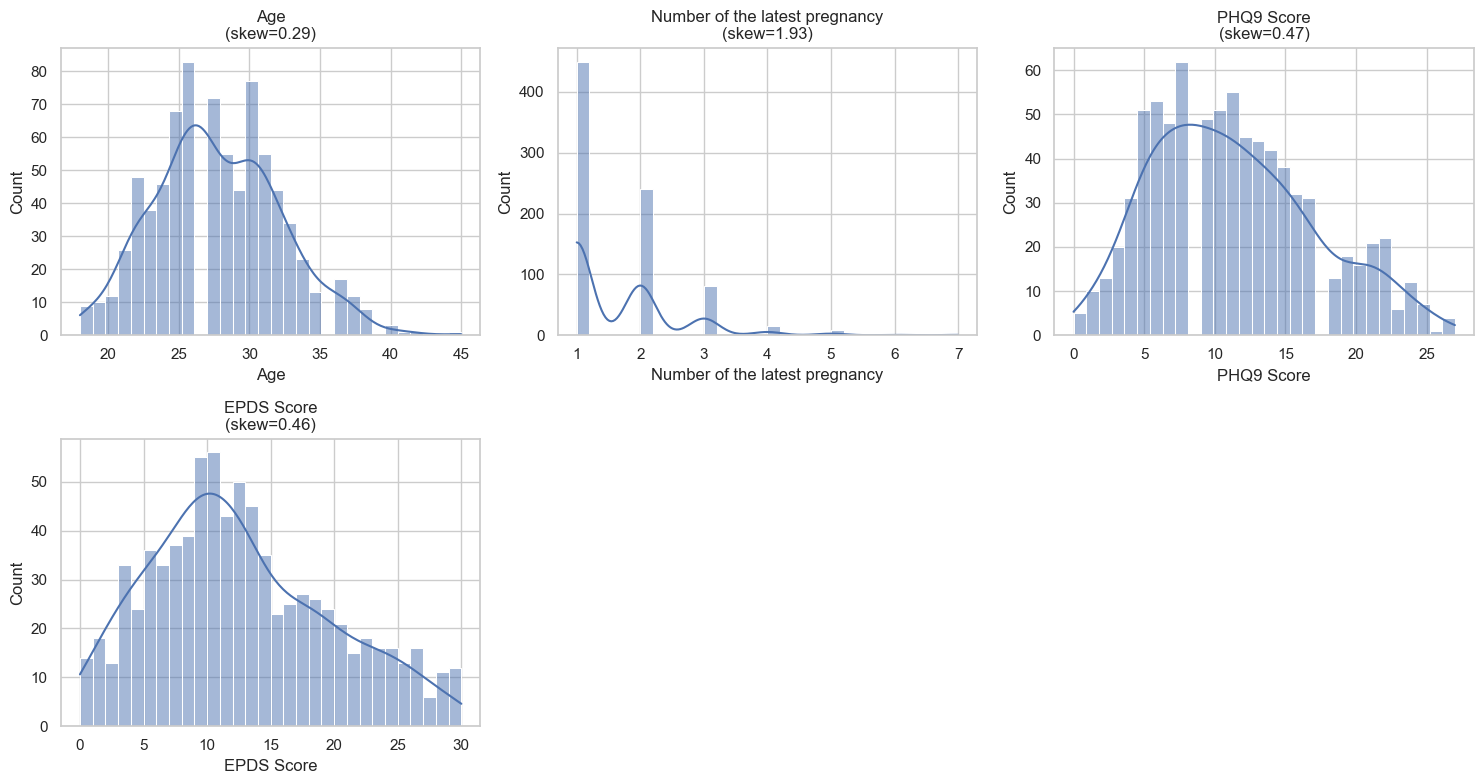

In [27]:
# Exclude 'sr' or similar non-informative numeric columns
# num_cols_clean = [c for c in num_cols if c.lower() not in ['sr', 's.no', 'serial', 'id']]

# Plot histograms for numeric columns
n = len(num_cols)
if n == 0:
    print("No numeric columns detected (after removing ID fields).")
else:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(5 * ncols, 4 * nrows))
    for i, c in enumerate(num_cols, 1):
        plt.subplot(nrows, ncols, i)
        sns.histplot(df[c].dropna(), kde=True, bins=30)
        plt.title(f"{c}\n(skew={df[c].dropna().skew():.2f})")
    plt.tight_layout()
    plt.show()


## Top 5 numeric plots (choosing & statistically explanating)

Top 5 numeric features (by variance): ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']


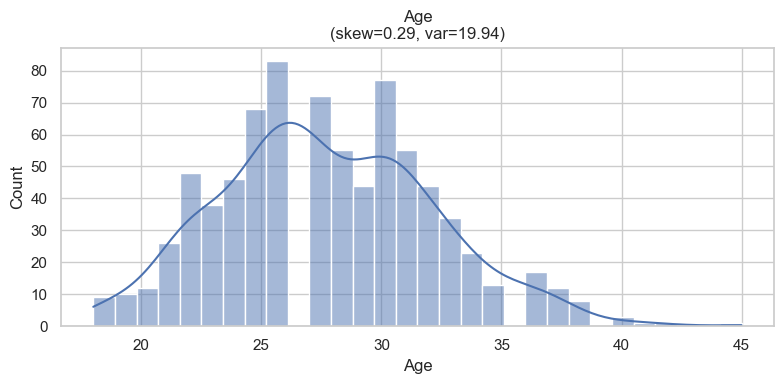

Summary for Age: mean=27.73, median=27.00, min=18.00, max=45.00, skew=0.29, var=19.94



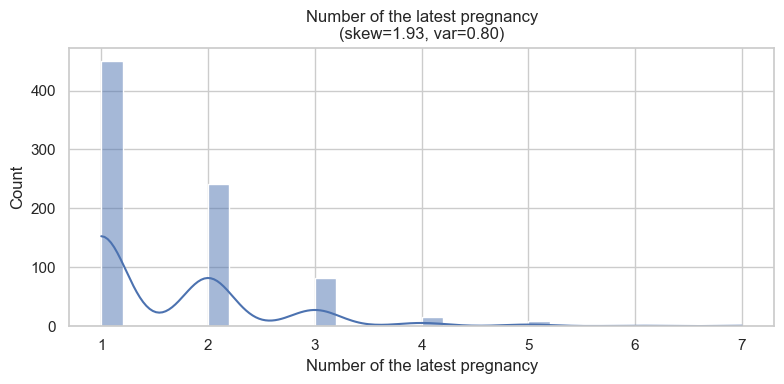

Summary for Number of the latest pregnancy: mean=1.63, median=1.00, min=1.00, max=7.00, skew=1.93, var=0.80



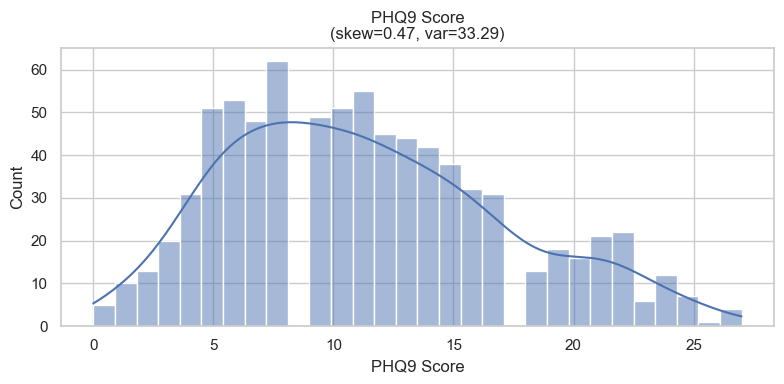

Summary for PHQ9 Score: mean=11.31, median=11.00, min=0.00, max=27.00, skew=0.47, var=33.29



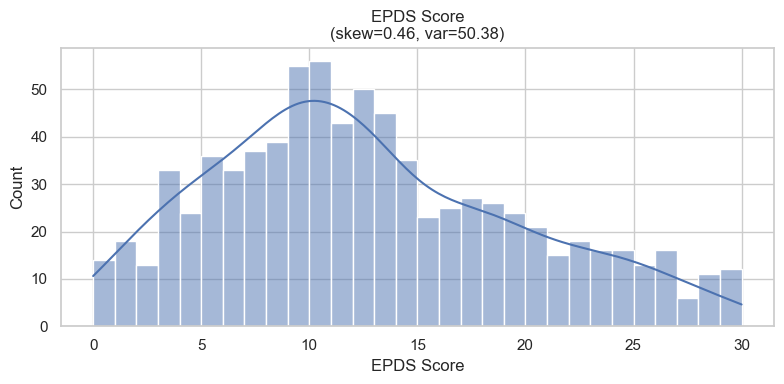

Summary for EPDS Score: mean=12.46, median=11.00, min=0.00, max=30.00, skew=0.46, var=50.38



In [28]:
# Replace 'target' with the actual target column name if known, e.g. 'PHQ9 Result' or 'EPDS Result'
target_col = 'EPDS Result' if 'EPDS Result' in df.columns else None  

# Identify ID-like non-informative numeric columns (plot them separately)
id_like = [c for c in num_cols if c.lower() in ['sr', 's.no', 'serial', 'id']]
num_cols_clean = [c for c in num_cols if c not in id_like]

# Select top 5 most important numeric features (by variance) from the informative set
if len(num_cols_clean) > 5:
    variances = df[num_cols_clean].var().sort_values(ascending=False)
    top5 = variances.head(5).index.tolist()
else:
    top5 = num_cols_clean

print("Top 5 numeric features (by variance):", top5)

# Plot each of the top-5 in its own figure for clearer inspection
for c in top5:
    data_c = df[c].dropna()
    skew_c = data_c.skew() if not data_c.empty else float('nan')
    var_c = data_c.var() if not data_c.empty else float('nan')
    mean_c = data_c.mean() if not data_c.empty else float('nan')
    median_c = data_c.median() if not data_c.empty else float('nan')
    min_c = data_c.min() if not data_c.empty else float('nan')
    max_c = data_c.max() if not data_c.empty else float('nan')
    plt.figure(figsize=(8,4))
    sns.histplot(data_c, kde=True, bins=30)
    plt.title(f"{c}\n(skew={skew_c:.2f}, var={var_c:.2f})")
    plt.tight_layout()
    plt.show()
    # quick textual explanation template
    print(f"Summary for {c}: mean={mean_c:.2f}, median={median_c:.2f}, min={min_c:.2f}, max={max_c:.2f}, skew={skew_c:.2f}, var={var_c:.2f}\n")

# Display ID-like / non-informative numeric columns separately with a clear title
if len(id_like) > 0:
    if len(id_like) == 1:
        c = id_like[0]
        plt.figure(figsize=(8,3))
        sns.histplot(df[c].dropna(), kde=False, bins=30)
        plt.title("non-informative numeric columns: " + c)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(6 * len(id_like), 4))
        for i, c in enumerate(id_like, 1):
            plt.subplot(1, len(id_like), i)
            sns.histplot(df[c].dropna(), kde=False, bins=30)
            plt.title(c)
        plt.suptitle("non-informative numeric columns")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


## Text Normalization & Fuzzy Deduplication (Preserve NaN/None)


In [29]:
# Smart Text Normalization & Fuzzy Deduplication (Preserve NaN/None)

if not has_rapidfuzz:
    print("⚠ Warning: Skipping fuzzy deduplication (rapidfuzz not installed).")
    print("  Install with: pip install rapidfuzz")
else:
    df.columns = df.columns.str.encode('ascii', 'ignore').str.decode('ascii')
    plt.rcParams['font.family'] = 'DejaVu Sans'

    # --- STEP 1: Fix encoding issues ---
    def normalize_text(s):
        if isinstance(s, str):
            s = unicodedata.normalize('NFKD', s)
            s = s.replace('’', "'").replace('‘', "'").replace('“', '"').replace('”', '"')
            return s.strip()
        return s

    df = df.map(normalize_text)

    # --- STEP 2: Identify categorical columns ---
    cat_cols = df.select_dtypes(exclude=['number', 'bool']).columns.tolist()

    # --- STEP 3: Clean casing, spaces, punctuation ---
    def clean_string(s):
        if isinstance(s, str):
            s = s.lower().strip()
            s = s.replace('-', ' ').replace('_', ' ')
            s = ' '.join(s.split())  # remove extra spaces
            return s
        return s

    for col in cat_cols:
        df[col] = df[col].map(clean_string)

    # --- STEP 4: Fuzzy deduplication preserving NaNs as a counted category ---
    def fuzzy_standardize_column(series, threshold=85, sentinel='NaN', keep_missing_label=True):
        """
        - Treat missing values as a category by filling with `sentinel` before matching.
        - If keep_missing_label=True the output will contain the sentinel string (so missing counts as a category).
          If False, sentinel is converted back to np.nan at the end (preserve NaN).
        """
        # Work on a filled series so missing is included in unique values
        filled = series.fillna(sentinel).astype(object)
        # Process values in descending frequency so the most common form becomes canonical
        unique_vals = pd.Series(filled.value_counts().index.tolist())
        mapping = {}

        for val in unique_vals:
            # first mapped value becomes canonical
            if not mapping:
                mapping[val] = val
                continue
            # fuzzy match against existing canonical keys
            match, score, _ = process.extractOne(val, list(mapping.keys()), scorer=fuzz.ratio)
            if score >= threshold:
                mapping[val] = match
            else:
                mapping[val] = val

        # apply mapping to filled series
        mapped = filled.map(mapping)

        # optionally convert sentinel back to np.nan to preserve original NaN semantics
        if not keep_missing_label:
            mapped = mapped.replace({sentinel: np.nan})

        return mapped, mapping

    # --- STEP 5: Apply fuzzy matching (keep_missing_label=True to count missing as a unique category) ---
    for col in cat_cols:
        print(f"\nCleaning column: {col}")
        # count uniques including missing by using fillna(sentinel)
        before_unique = df[col].fillna('NaN').unique()
        before_count = len([x for x in before_unique if x is not None])
        df[col], mapping = fuzzy_standardize_column(df[col], threshold=85, sentinel='NaN', keep_missing_label=True)
        after_unique = df[col].fillna('NaN').unique()
        n_before = len([x for x in before_unique if pd.notna(x)])
        n_after = len([x for x in after_unique if pd.notna(x)])
        print(f"  Unique before (counting missing): {n_before} → after: {n_after}")
        print("  Example mappings (changed values):")
        shown = 0
        for k, v in mapping.items():
            if k != v:
                print(f"    '{k}' → '{v}'")
                shown += 1
                if shown >= 6:
                    break

    # --- STEP 6: Check for non-ASCII characters ---
    for col in cat_cols:
        bad_chars = df[col].astype(str).str.contains(r'[^\x00-\x7F]', regex=True)
        if bad_chars.any():
            print(f"Warning: Non-ASCII characters remain in column '{col}'")

    print("\nNormalization & fuzzy deduplication complete (missing values can be counted as a category).")



⚠ Warning: Skipping fuzzy deduplication (rapidfuzz not installed).
  Install with: pip install rapidfuzz


## Individual Bar Chart for the categorical features

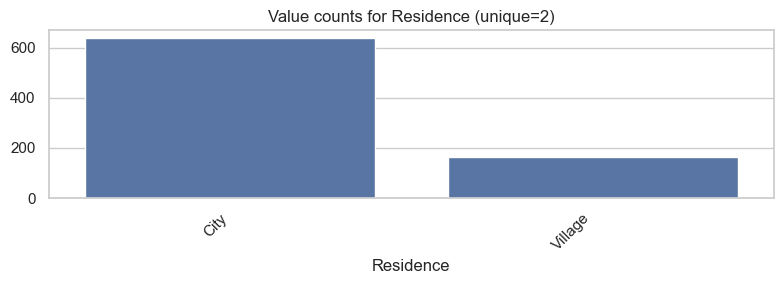

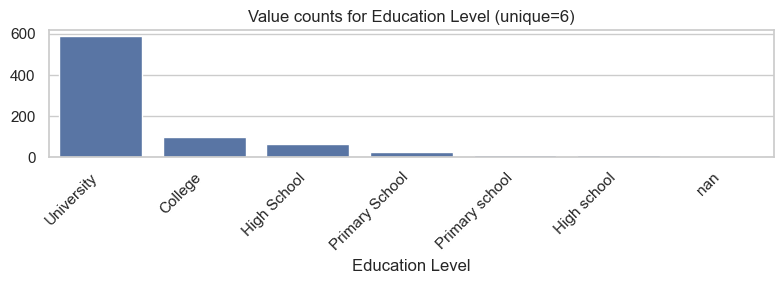

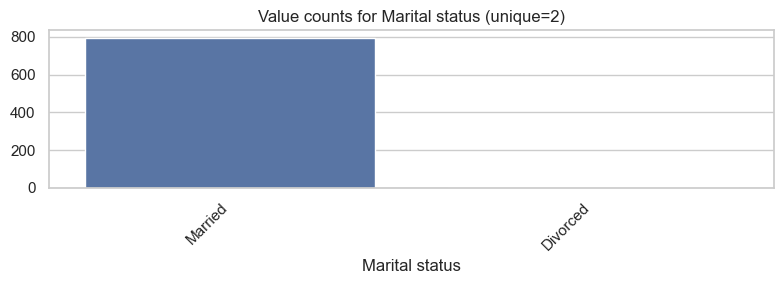

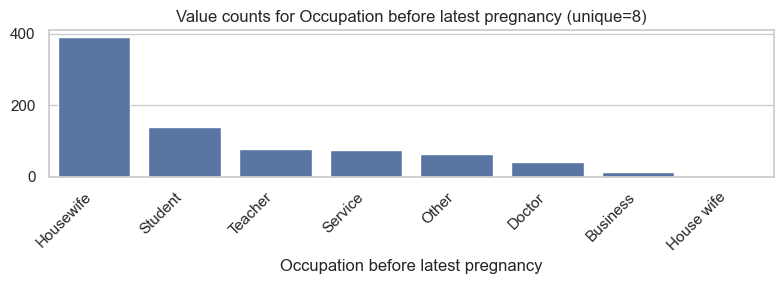

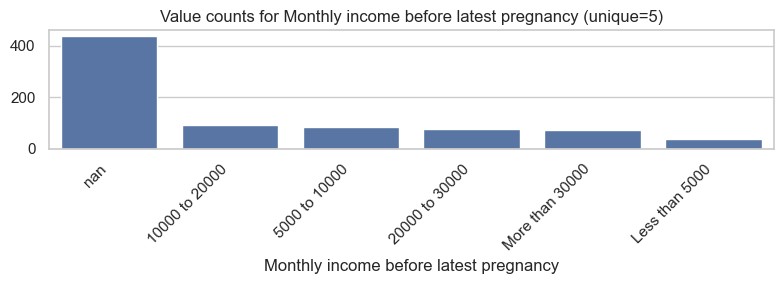

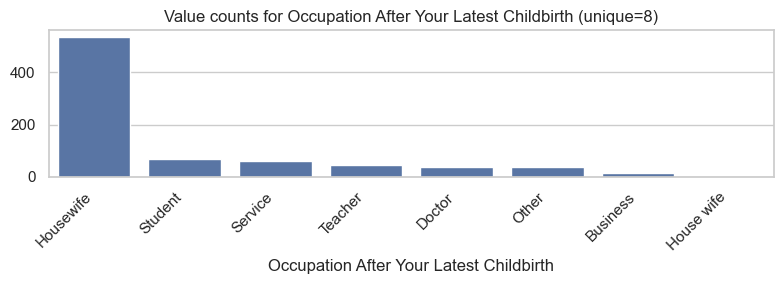

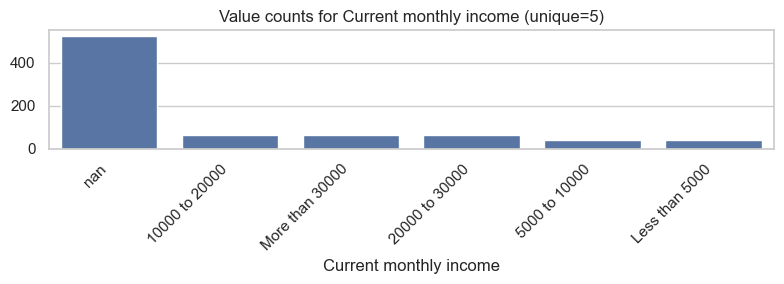

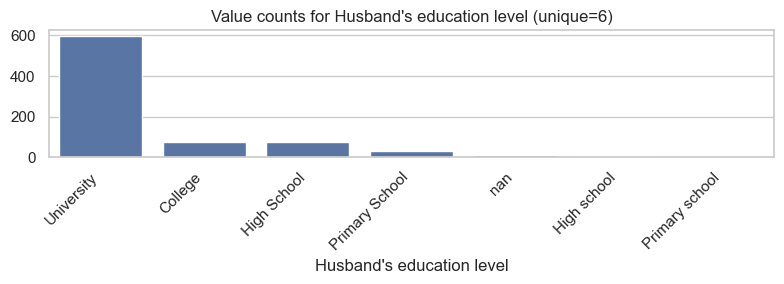

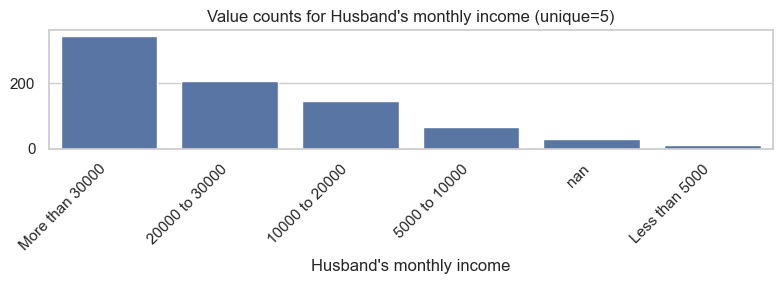

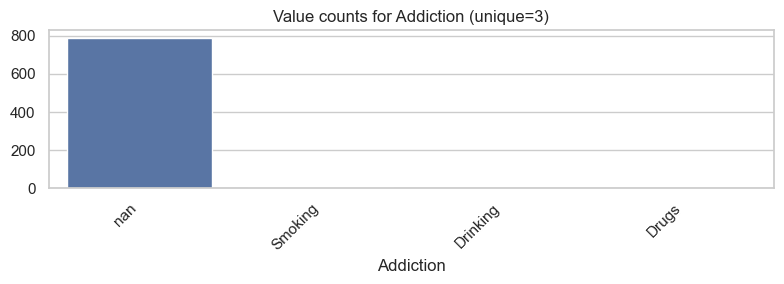

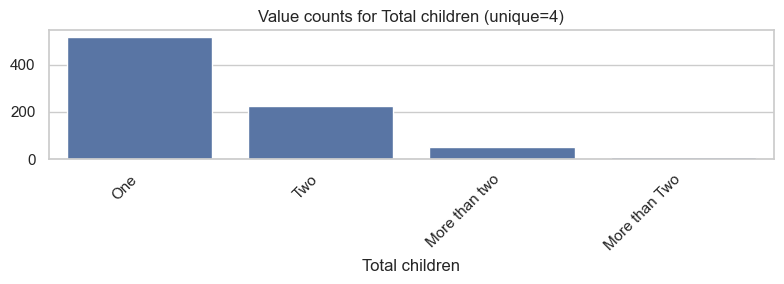

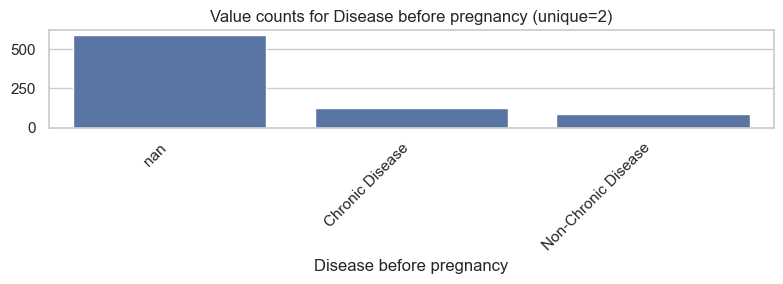

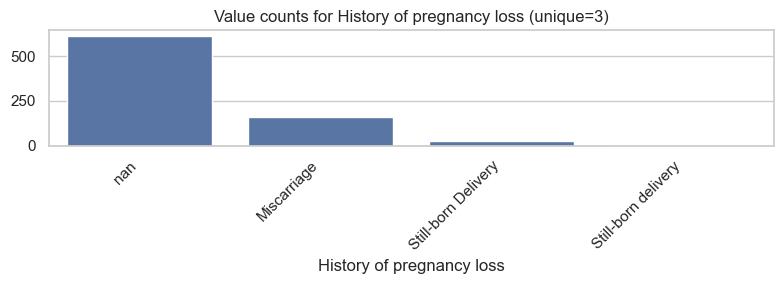

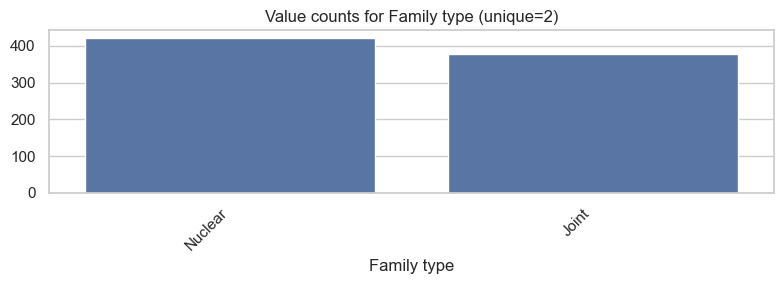

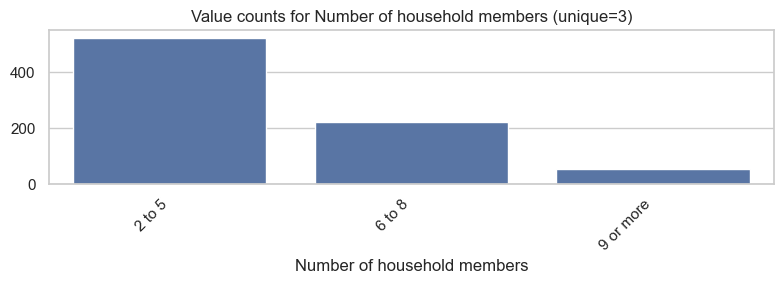

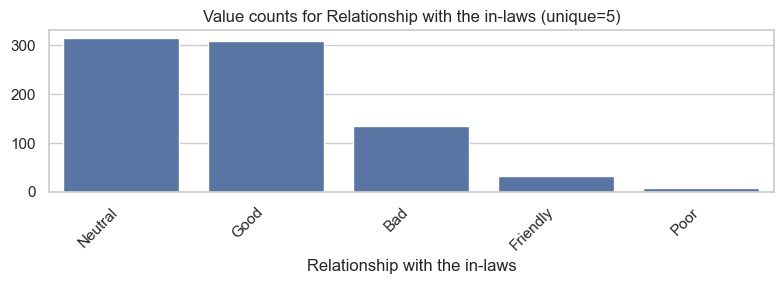

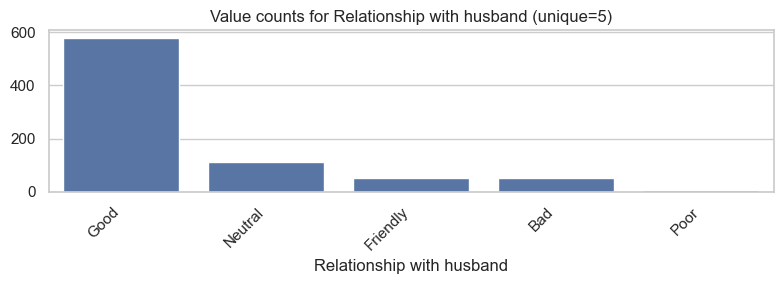

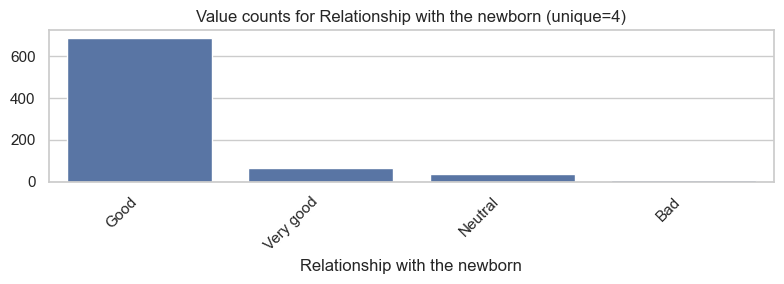

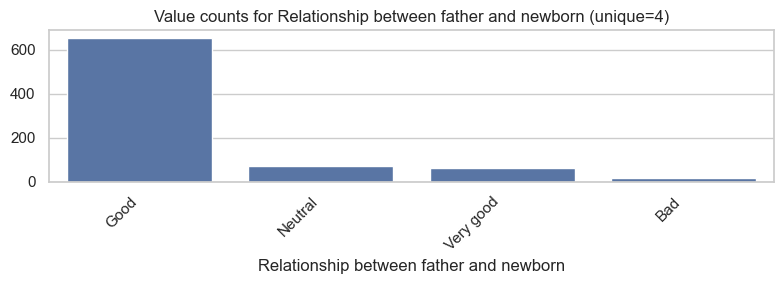

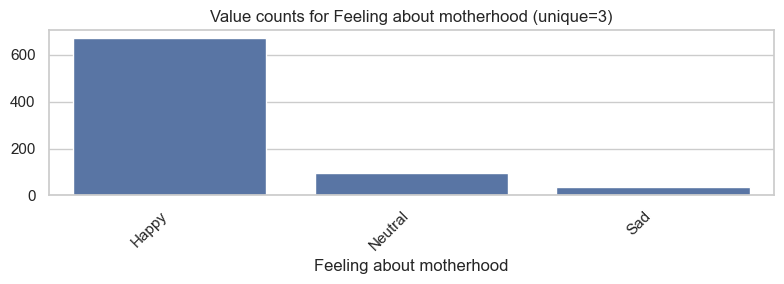

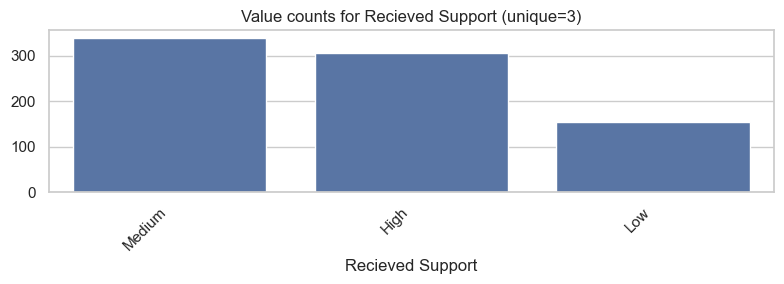

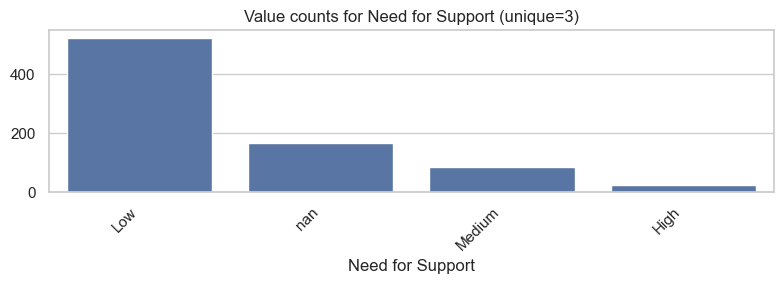

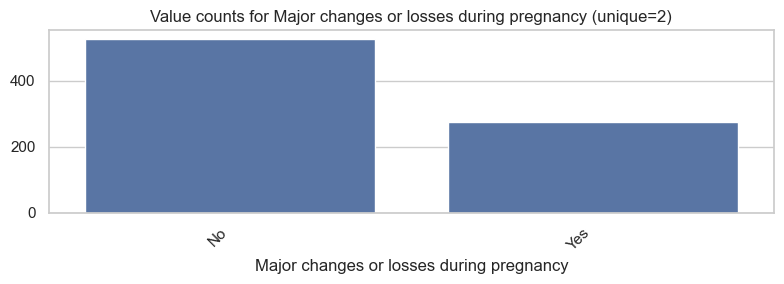

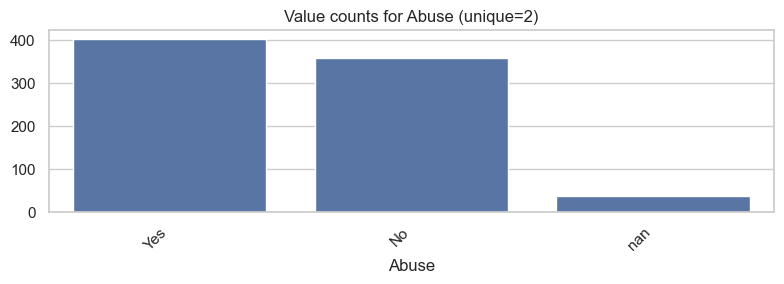

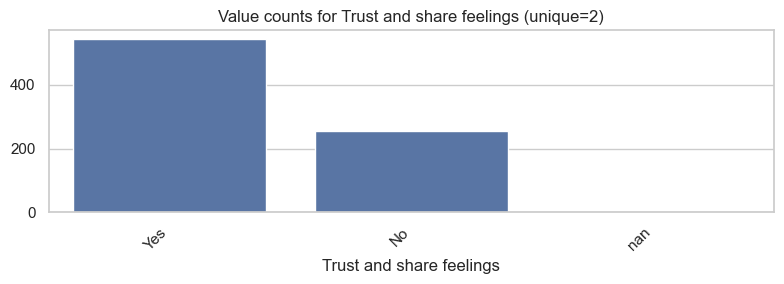

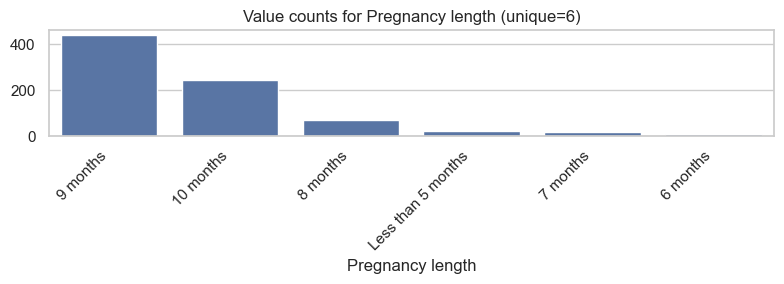

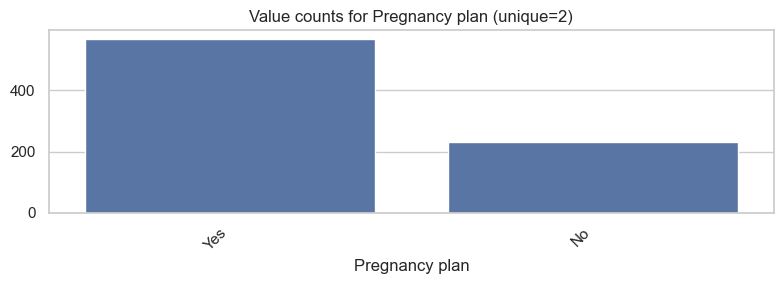

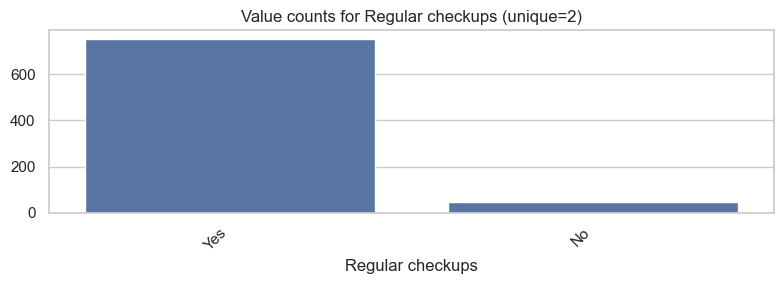

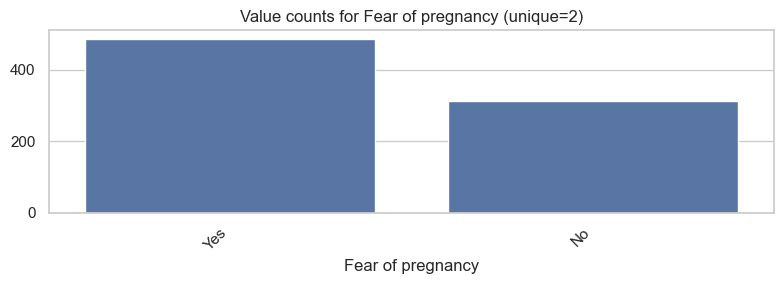

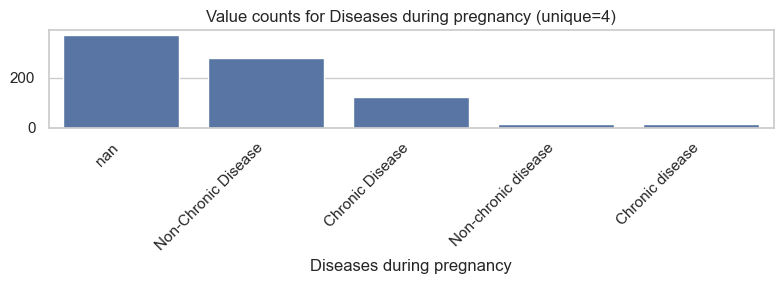

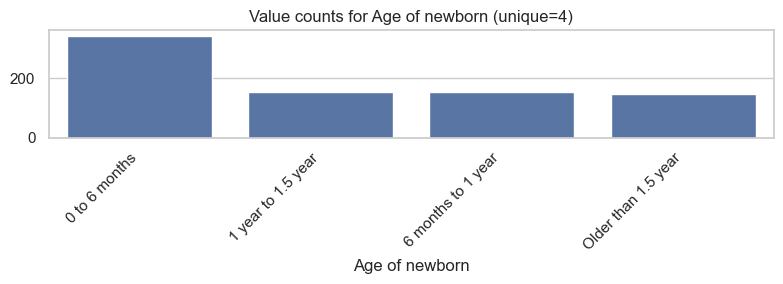

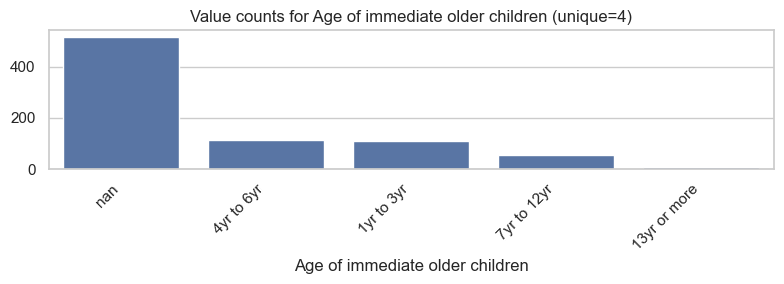

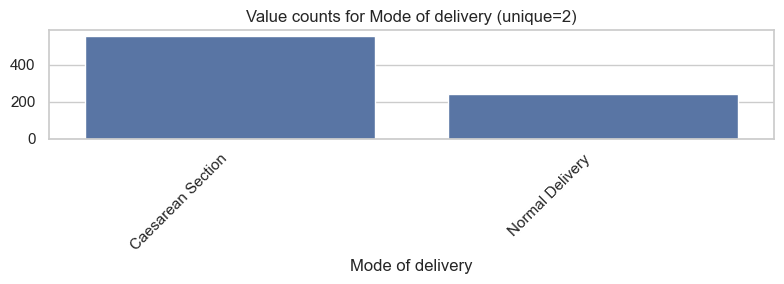

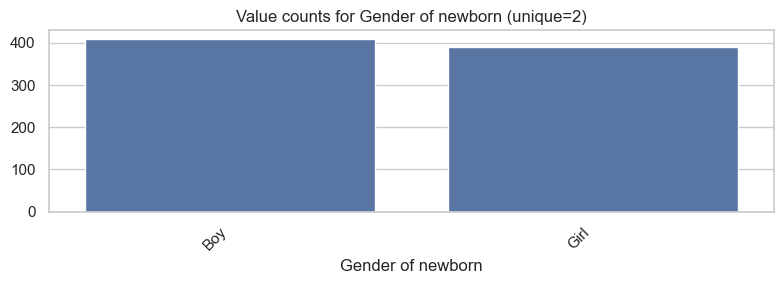

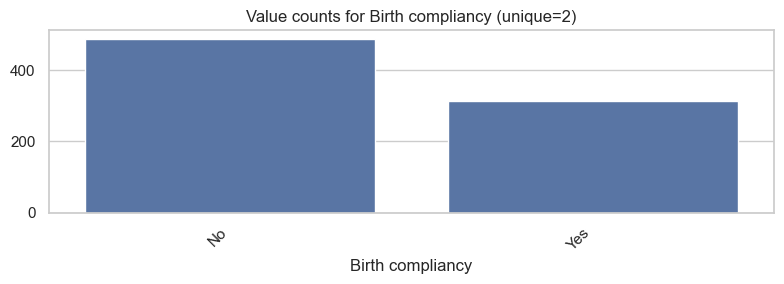

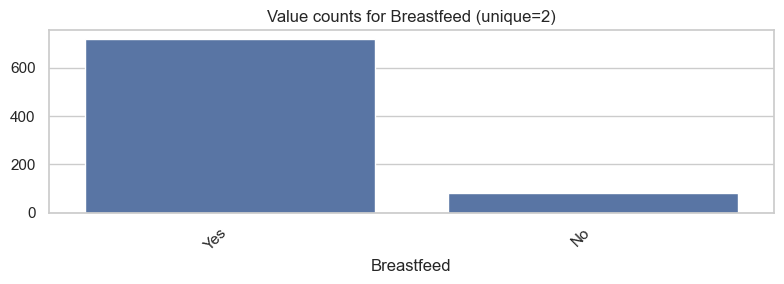

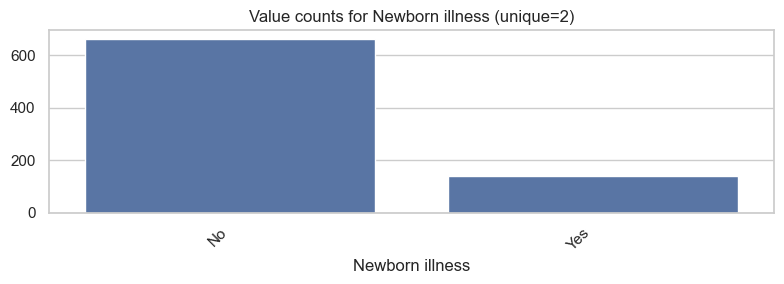

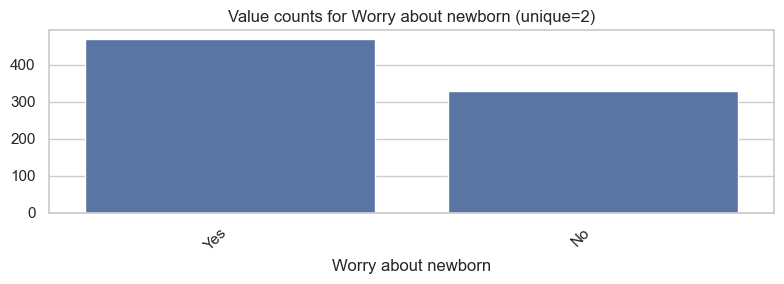

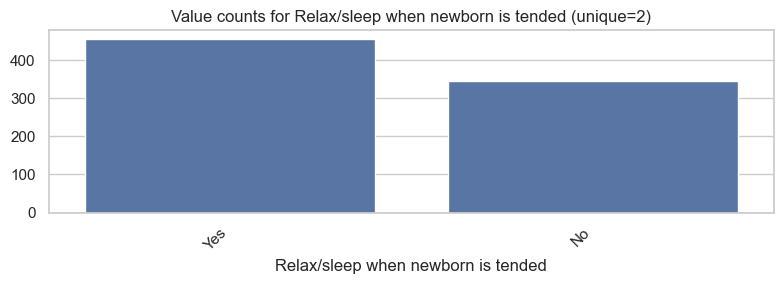

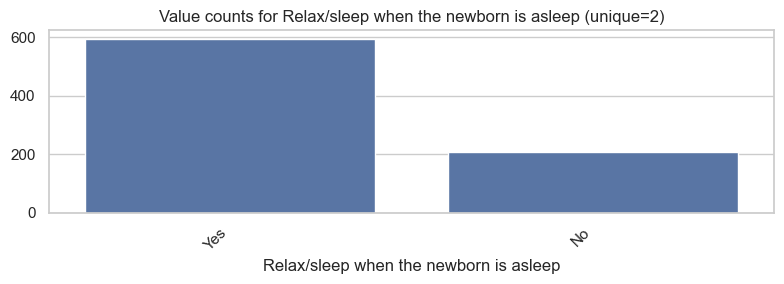

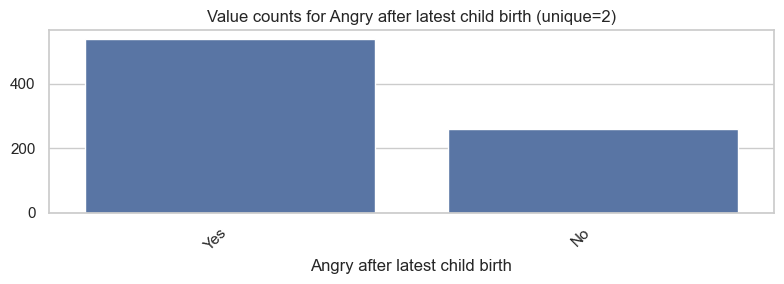

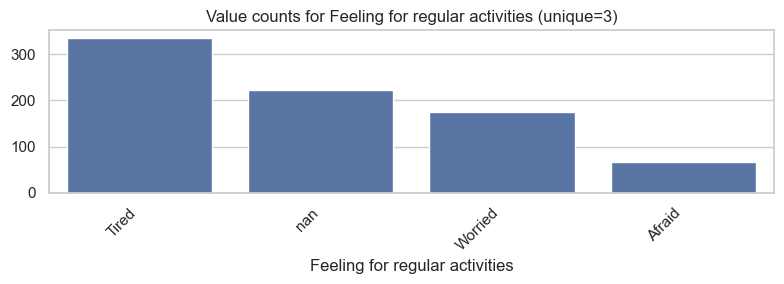

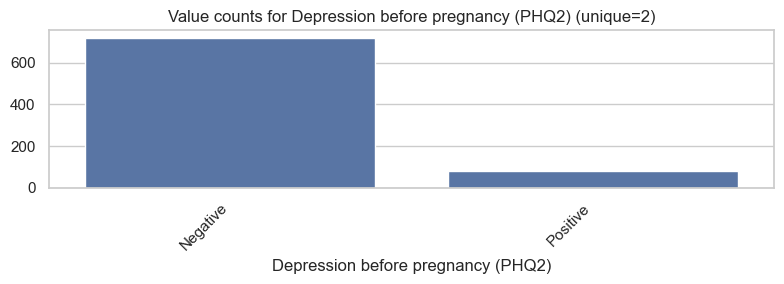

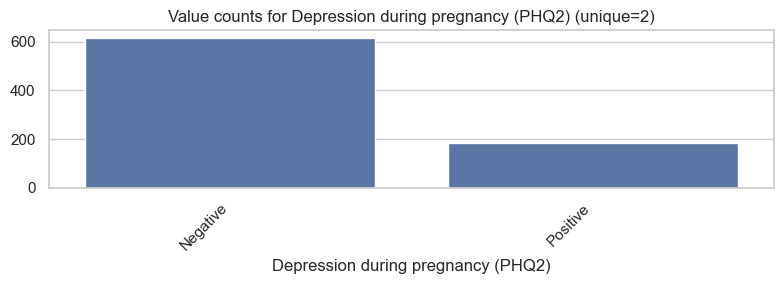

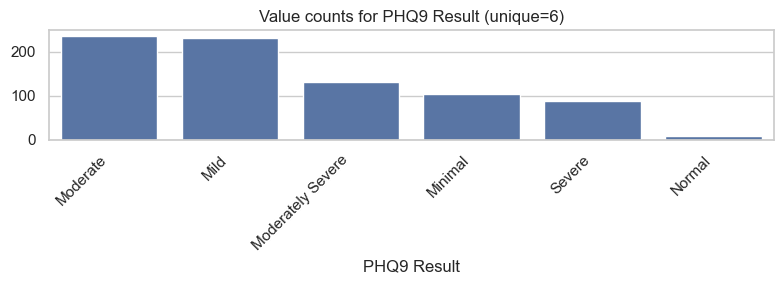

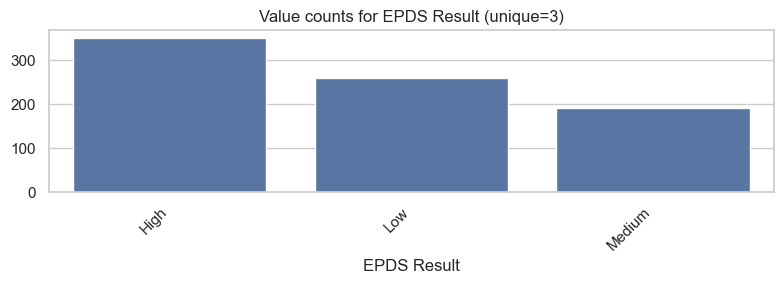

In [30]:
# For categorical features: value counts
if len(cat_cols) == 0:
    print("No categorical columns detected.")
else:
    for c in cat_cols:
        vc = df[c].value_counts(dropna=False)
        # limit plotting for very high-cardinality columns
        plt.figure(figsize=(8,3))
        if len(vc) <= 30:
            sns.barplot(x=vc.index.astype(str), y=vc.values)
            plt.xticks(rotation=45, ha='right')
        else:
            # show top 20 categories
            sns.barplot(x=vc.head(20).index.astype(str), y=vc.head(20).values)
            plt.xticks(rotation=45, ha='right')
        plt.title(f"Value counts for {c} (unique={df[c].nunique()})")
        plt.tight_layout()
        plt.show()


## Top 5 categorical plots (choosing & explaining including statistics)


Top-5 categorical columns selected for PPD analysis: ['Feeling about motherhood', 'Relationship with husband', 'History of pregnancy loss', 'Recieved Support', 'Depression during pregnancy (PHQ2)']


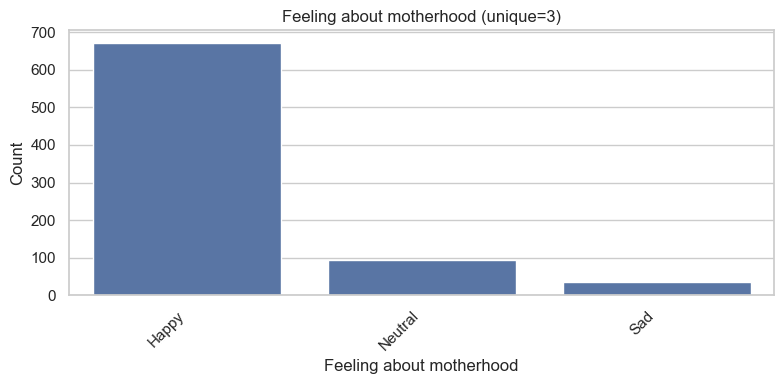


Explanation:
Maternal feelings toward the newborn and self-efficacy are direct psychological indicators of vulnerability.

--------------------------------------------------------------------------------

Value counts for 'Feeling about motherhood':
Feeling about motherhood
Happy      671
Neutral     94
Sad         35
Name: count, dtype: int64

Normalized (proportion) counts:
Feeling about motherhood
Happy      0.839
Neutral    0.118
Sad        0.044
Name: proportion, dtype: float64

--------------------------------------------------



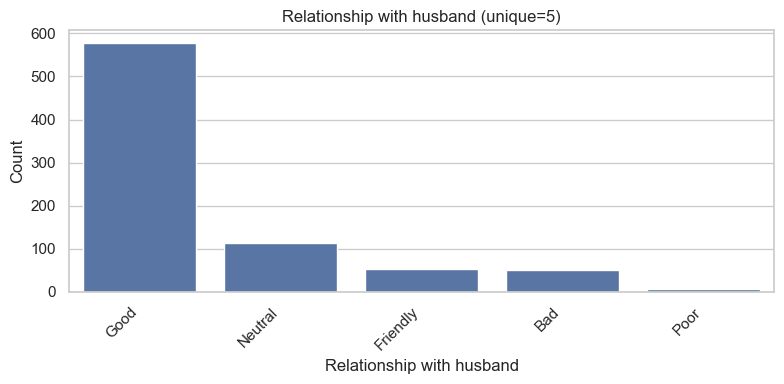


Explanation:
Marital relationship quality is crucial in Bangladeshi households where extended family often influences daily life.

--------------------------------------------------------------------------------

Value counts for 'Relationship with husband':
Relationship with husband
Good        578
Neutral     113
Friendly     52
Bad          51
Poor          6
Name: count, dtype: int64

Normalized (proportion) counts:
Relationship with husband
Good        0.722
Neutral     0.141
Friendly    0.065
Bad         0.064
Poor        0.008
Name: proportion, dtype: float64

--------------------------------------------------



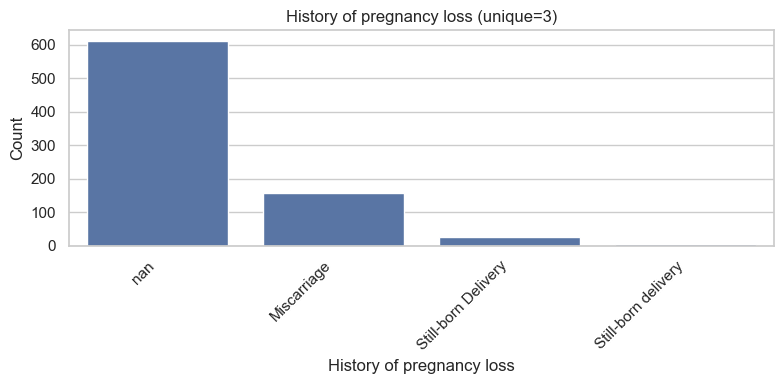


Explanation:
Prior loss is stressful and can increase anxiety and PPD risk.

--------------------------------------------------------------------------------

Value counts for 'History of pregnancy loss':
History of pregnancy loss
NaN                    613
Miscarriage            158
Still-born Delivery     24
Still-born delivery      5
Name: count, dtype: int64

Normalized (proportion) counts:
History of pregnancy loss
Miscarriage            0.845
Still-born Delivery    0.128
Still-born delivery    0.027
Name: proportion, dtype: float64

--------------------------------------------------



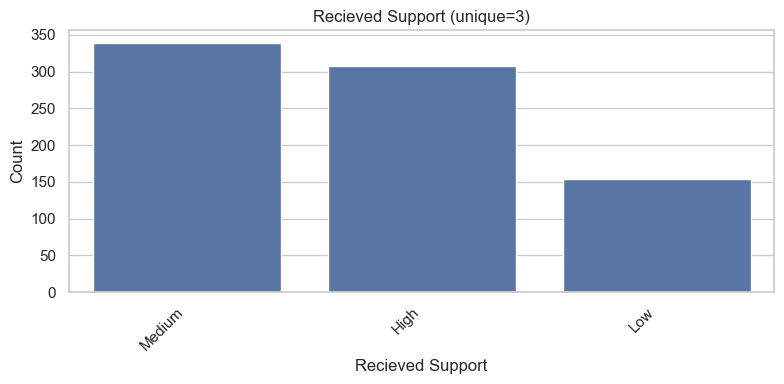


Explanation:
Social support (from husband, family, friends) buffers against PPD.

--------------------------------------------------------------------------------

Value counts for 'Recieved Support':
Recieved Support
Medium    339
High      307
Low       154
Name: count, dtype: int64

Normalized (proportion) counts:
Recieved Support
Medium    0.424
High      0.384
Low       0.192
Name: proportion, dtype: float64

--------------------------------------------------



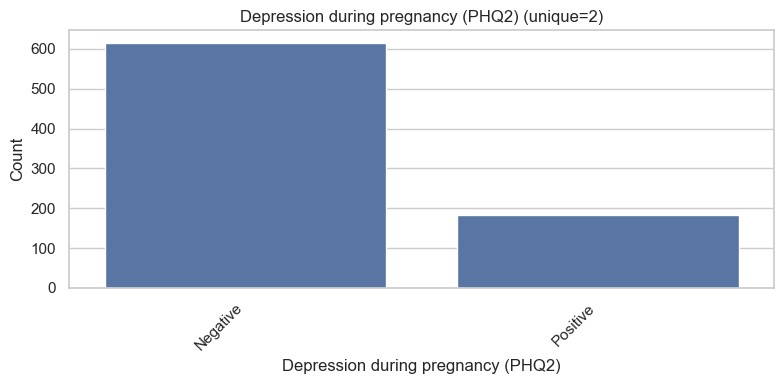


Explanation:
Pre-existing or concurrent depression is the strongest predictor of PPD.

--------------------------------------------------------------------------------

Value counts for 'Depression during pregnancy (PHQ2)':
Depression during pregnancy (PHQ2)
Negative    616
Positive    184
Name: count, dtype: int64

Normalized (proportion) counts:
Depression during pregnancy (PHQ2)
Negative    0.77
Positive    0.23
Name: proportion, dtype: float64

--------------------------------------------------



In [31]:
# --- Top 5 conceptually relevant categorical plots for PPD detection ---
top5_cat = [
    'Feeling about motherhood',
    'Relationship with husband',
    'History of pregnancy loss',
    'Recieved Support',
    'Depression during pregnancy (PHQ2)'
]
# Explanations dictionary
explanations = {
    'Depression during pregnancy (PHQ2)': "Pre-existing or concurrent depression is the strongest predictor of PPD.",
    'Recieved Support': "Social support (from husband, family, friends) buffers against PPD.",
    'Relationship with husband': "Marital relationship quality is crucial in Bangladeshi households where extended family often influences daily life.",
    'History of pregnancy loss': "Prior loss is stressful and can increase anxiety and PPD risk.",
    'Feeling about motherhood': "Maternal feelings toward the newborn and self-efficacy are direct psychological indicators of vulnerability."
}

print("Top-5 categorical columns selected for PPD analysis:", top5_cat)

for c in top5_cat:
    vc = df[c].value_counts(dropna=False)
    vc_norm = df[c].value_counts(normalize=True).round(3)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=vc.index.astype(str), y=vc.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count")
    plt.title(f"{c} (unique={df[c].nunique()})")
    plt.tight_layout()
    plt.show()

        # Print explanation
    print("\nExplanation:")
    print(explanations[c])
    
    print("\n" + "-"*80 + "\n")
    
    print(f"Value counts for '{c}':")
    print(vc)
    print("\nNormalized (proportion) counts:")
    print(vc_norm)
    print("\n" + "-"*50 + "\n")


## Categorical vs Categorical


Analyzing 'Feeling about motherhood' vs EPDS Result

Cross-tabulation:


EPDS Result,High,Low,Medium
Feeling about motherhood,,,
Happy,254,247,170
Neutral,62,13,19
Sad,34,0,1



Normalized proportions (row-wise):


EPDS Result,High,Low,Medium
Feeling about motherhood,,,
Happy,0.379,0.368,0.253
Neutral,0.660,0.138,0.202
Sad,0.971,0.000,0.029


Explanation for 'Feeling about motherhood': Maternal feelings toward the newborn and self-efficacy are direct psychological indicators of vulnerability.

--------------------------------------------------------------------------------

Analyzing 'Relationship with husband' vs EPDS Result

Cross-tabulation:


EPDS Result,High,Low,Medium
Relationship with husband,,,
Bad,48,1,2
Friendly,11,29,12
Good,216,207,155
Neutral,71,22,20
Poor,4,1,1



Normalized proportions (row-wise):


EPDS Result,High,Low,Medium
Relationship with husband,,,
Bad,0.941,0.020,0.039
Friendly,0.212,0.558,0.231
Good,0.374,0.358,0.268
Neutral,0.628,0.195,0.177
Poor,0.667,0.167,0.167


Explanation for 'Relationship with husband': Marital relationship quality is crucial in Bangladeshi households where extended family often influences daily life.

--------------------------------------------------------------------------------

Analyzing 'History of pregnancy loss' vs EPDS Result

Cross-tabulation:


EPDS Result,High,Low,Medium
History of pregnancy loss,,,
Miscarriage,73,51,34
Still-born Delivery,8,9,7
Still-born delivery,3,1,1



Normalized proportions (row-wise):


EPDS Result,High,Low,Medium
History of pregnancy loss,,,
Miscarriage,0.462,0.323,0.215
Still-born Delivery,0.333,0.375,0.292
Still-born delivery,0.600,0.200,0.200


Explanation for 'History of pregnancy loss': Prior loss is stressful and can increase anxiety and PPD risk.

--------------------------------------------------------------------------------

Analyzing 'Recieved Support' vs EPDS Result

Cross-tabulation:


EPDS Result,High,Low,Medium
Recieved Support,,,
High,83,143,81
Low,88,41,25
Medium,179,76,84



Normalized proportions (row-wise):


EPDS Result,High,Low,Medium
Recieved Support,,,
High,0.270,0.466,0.264
Low,0.571,0.266,0.162
Medium,0.528,0.224,0.248


Explanation for 'Recieved Support': Social support (from husband, family, friends) buffers against PPD.

--------------------------------------------------------------------------------

Analyzing 'Depression during pregnancy (PHQ2)' vs EPDS Result

Cross-tabulation:


EPDS Result,High,Low,Medium
Depression during pregnancy (PHQ2),,,
Negative,242,231,143
Positive,108,29,47



Normalized proportions (row-wise):


EPDS Result,High,Low,Medium
Depression during pregnancy (PHQ2),,,
Negative,0.393,0.375,0.232
Positive,0.587,0.158,0.255


Explanation for 'Depression during pregnancy (PHQ2)': Pre-existing or concurrent depression is the strongest predictor of PPD.

--------------------------------------------------------------------------------



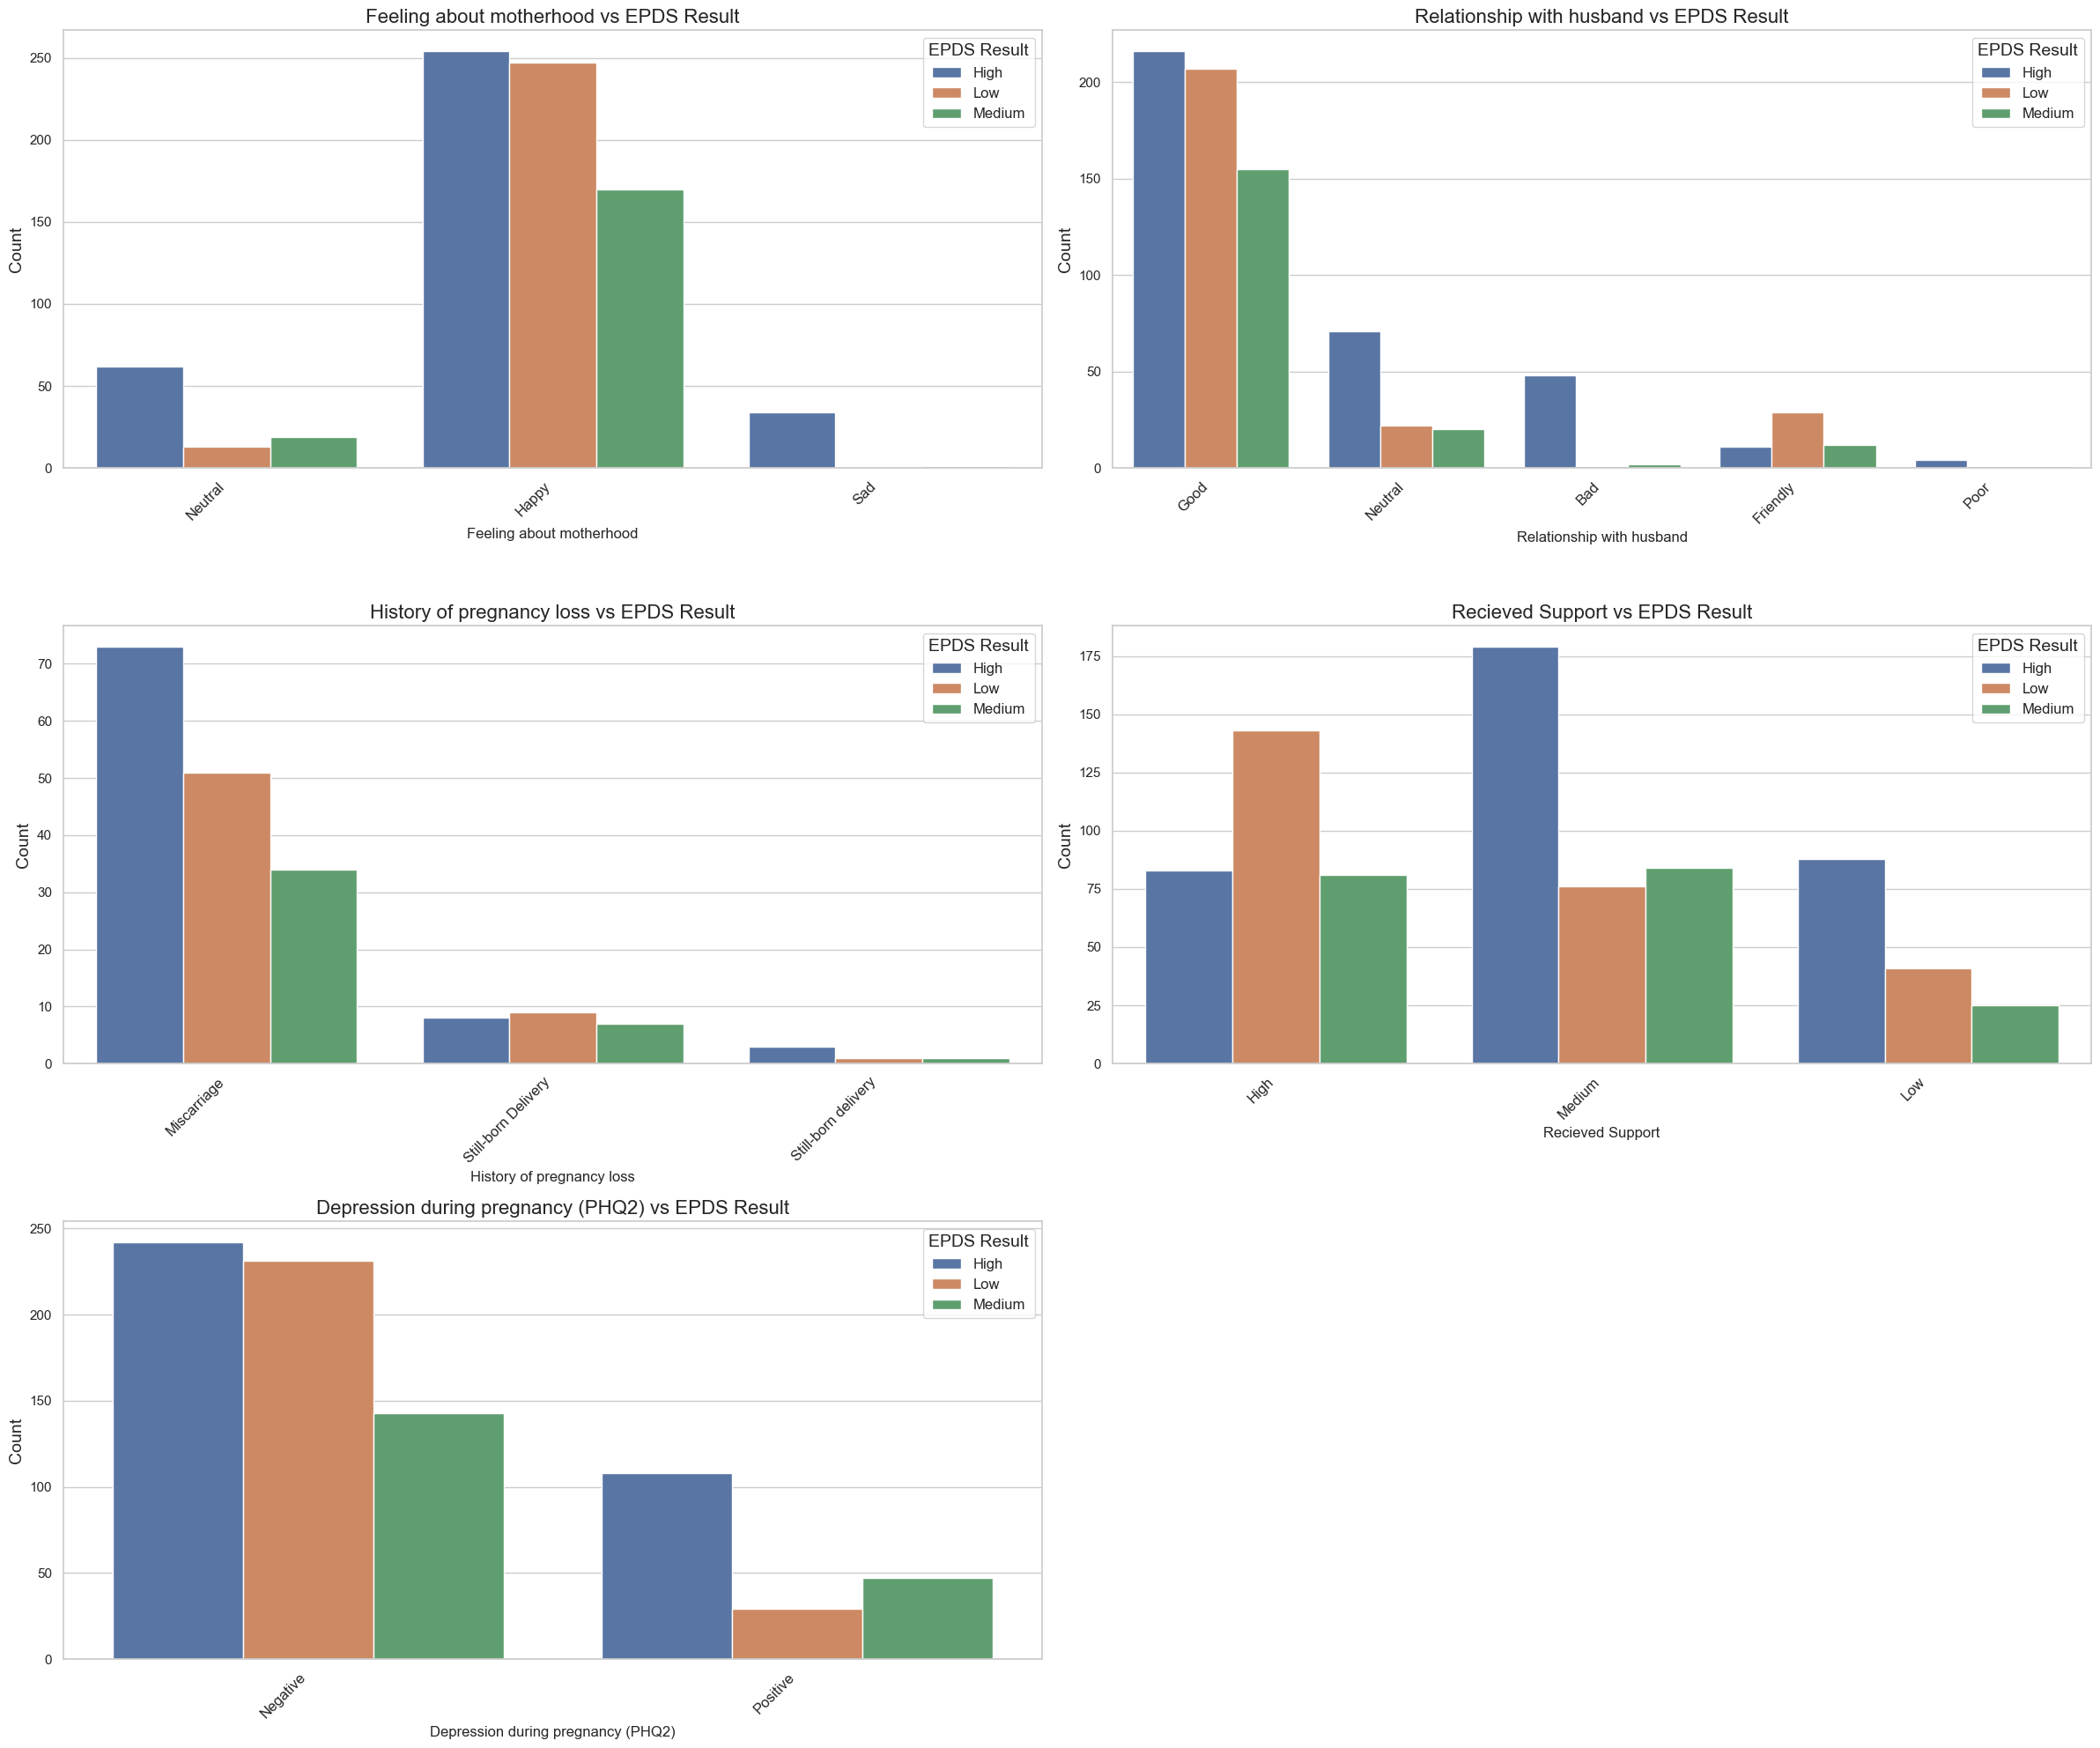

In [32]:
# --- Categorical vs Categorical analysis for PPD (single figure, blue/orange) ---
target_col = 'EPDS Result'

# Increase figure size for readability
fig, axes = plt.subplots(3, 2, figsize=(24, 20))  # bigger width & height
axes = axes.flatten()

for i, c in enumerate(top5_cat):
    ax = axes[i]
    
    # Countplot
    sns.countplot(data=df, x=c, hue=target_col, ax=ax)
    
    # Rotate x-axis labels safely
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    
    # Improve y-axis and title font sizes
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title(f"{c} vs {target_col}", fontsize=16)
    
    # Legend fonts
    ax.legend(title=target_col, fontsize=12, title_fontsize=14)
    
    # --- Text outputs below each subplot ---
    print(f"Analyzing '{c}' vs {target_col}")
    
    # Cross-tabulation
    ct = pd.crosstab(df[c], df[target_col])
    print("\nCross-tabulation:")
    display(ct)
    
    # Normalized proportions
    ct_norm = pd.crosstab(df[c], df[target_col], normalize='index').round(3)
    print("\nNormalized proportions (row-wise):")
    display(ct_norm)
    
    # Explanation printed below tables
    print(f"Explanation for '{c}': {explanations[c]}")
    print("\n" + "-"*80 + "\n")

# Remove empty subplot if exists
if len(top5_cat) < len(axes):
    for j in range(len(top5_cat), len(axes)):
        fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


## Categorical vs Numerical


Analyzing 'Age' vs 


,count,mean,std,min,25%,50%,75%,max
Feeling about motherhood,,,,,,,,
Happy,671.0,27.570790,4.434328,18.0,25.00,27.0,30.5,45.0
Neutral,94.0,28.968085,4.466006,21.0,25.25,29.0,32.0,42.0
Sad,35.0,27.342857,4.658596,18.0,24.00,26.0,30.0,40.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Relationship with husband,,,,,,,,
Bad,51.0,27.568627,3.556711,18.0,26.0,28.0,30.00,35.0
Friendly,52.0,25.903846,4.521234,18.0,22.0,26.0,28.00,37.0
Good,578.0,27.683391,4.388235,18.0,25.0,27.0,31.00,41.0
Neutral,113.0,28.752212,4.943486,18.0,25.0,28.0,32.00,45.0
Poor,6.0,29.500000,4.415880,25.0,26.0,28.5,33.25,35.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
History of pregnancy loss,,,,,,,,
Miscarriage,158.0,29.006329,4.283722,18.0,26.0,30.0,32.0,40.0
Still-born Delivery,24.0,29.791667,4.872096,22.0,26.0,28.5,33.0,40.0
Still-born delivery,5.0,28.600000,5.856620,23.0,23.0,30.0,30.0,37.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Recieved Support,,,,,,,,
High,307.0,26.957655,4.420115,18.0,24.0,27.0,30.00,45.0
Low,154.0,28.487013,4.865830,18.0,25.0,28.0,31.75,42.0
Medium,339.0,28.073746,4.220672,18.0,25.0,28.0,31.00,41.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Depression during pregnancy (PHQ2),,,,,,,,
Negative,616.0,27.824675,4.552327,18.0,25.0,27.0,31.0,45.0
Positive,184.0,27.391304,4.156650,18.0,25.0,27.0,30.0,40.0



----------------------------------------------------------------------------------------------------



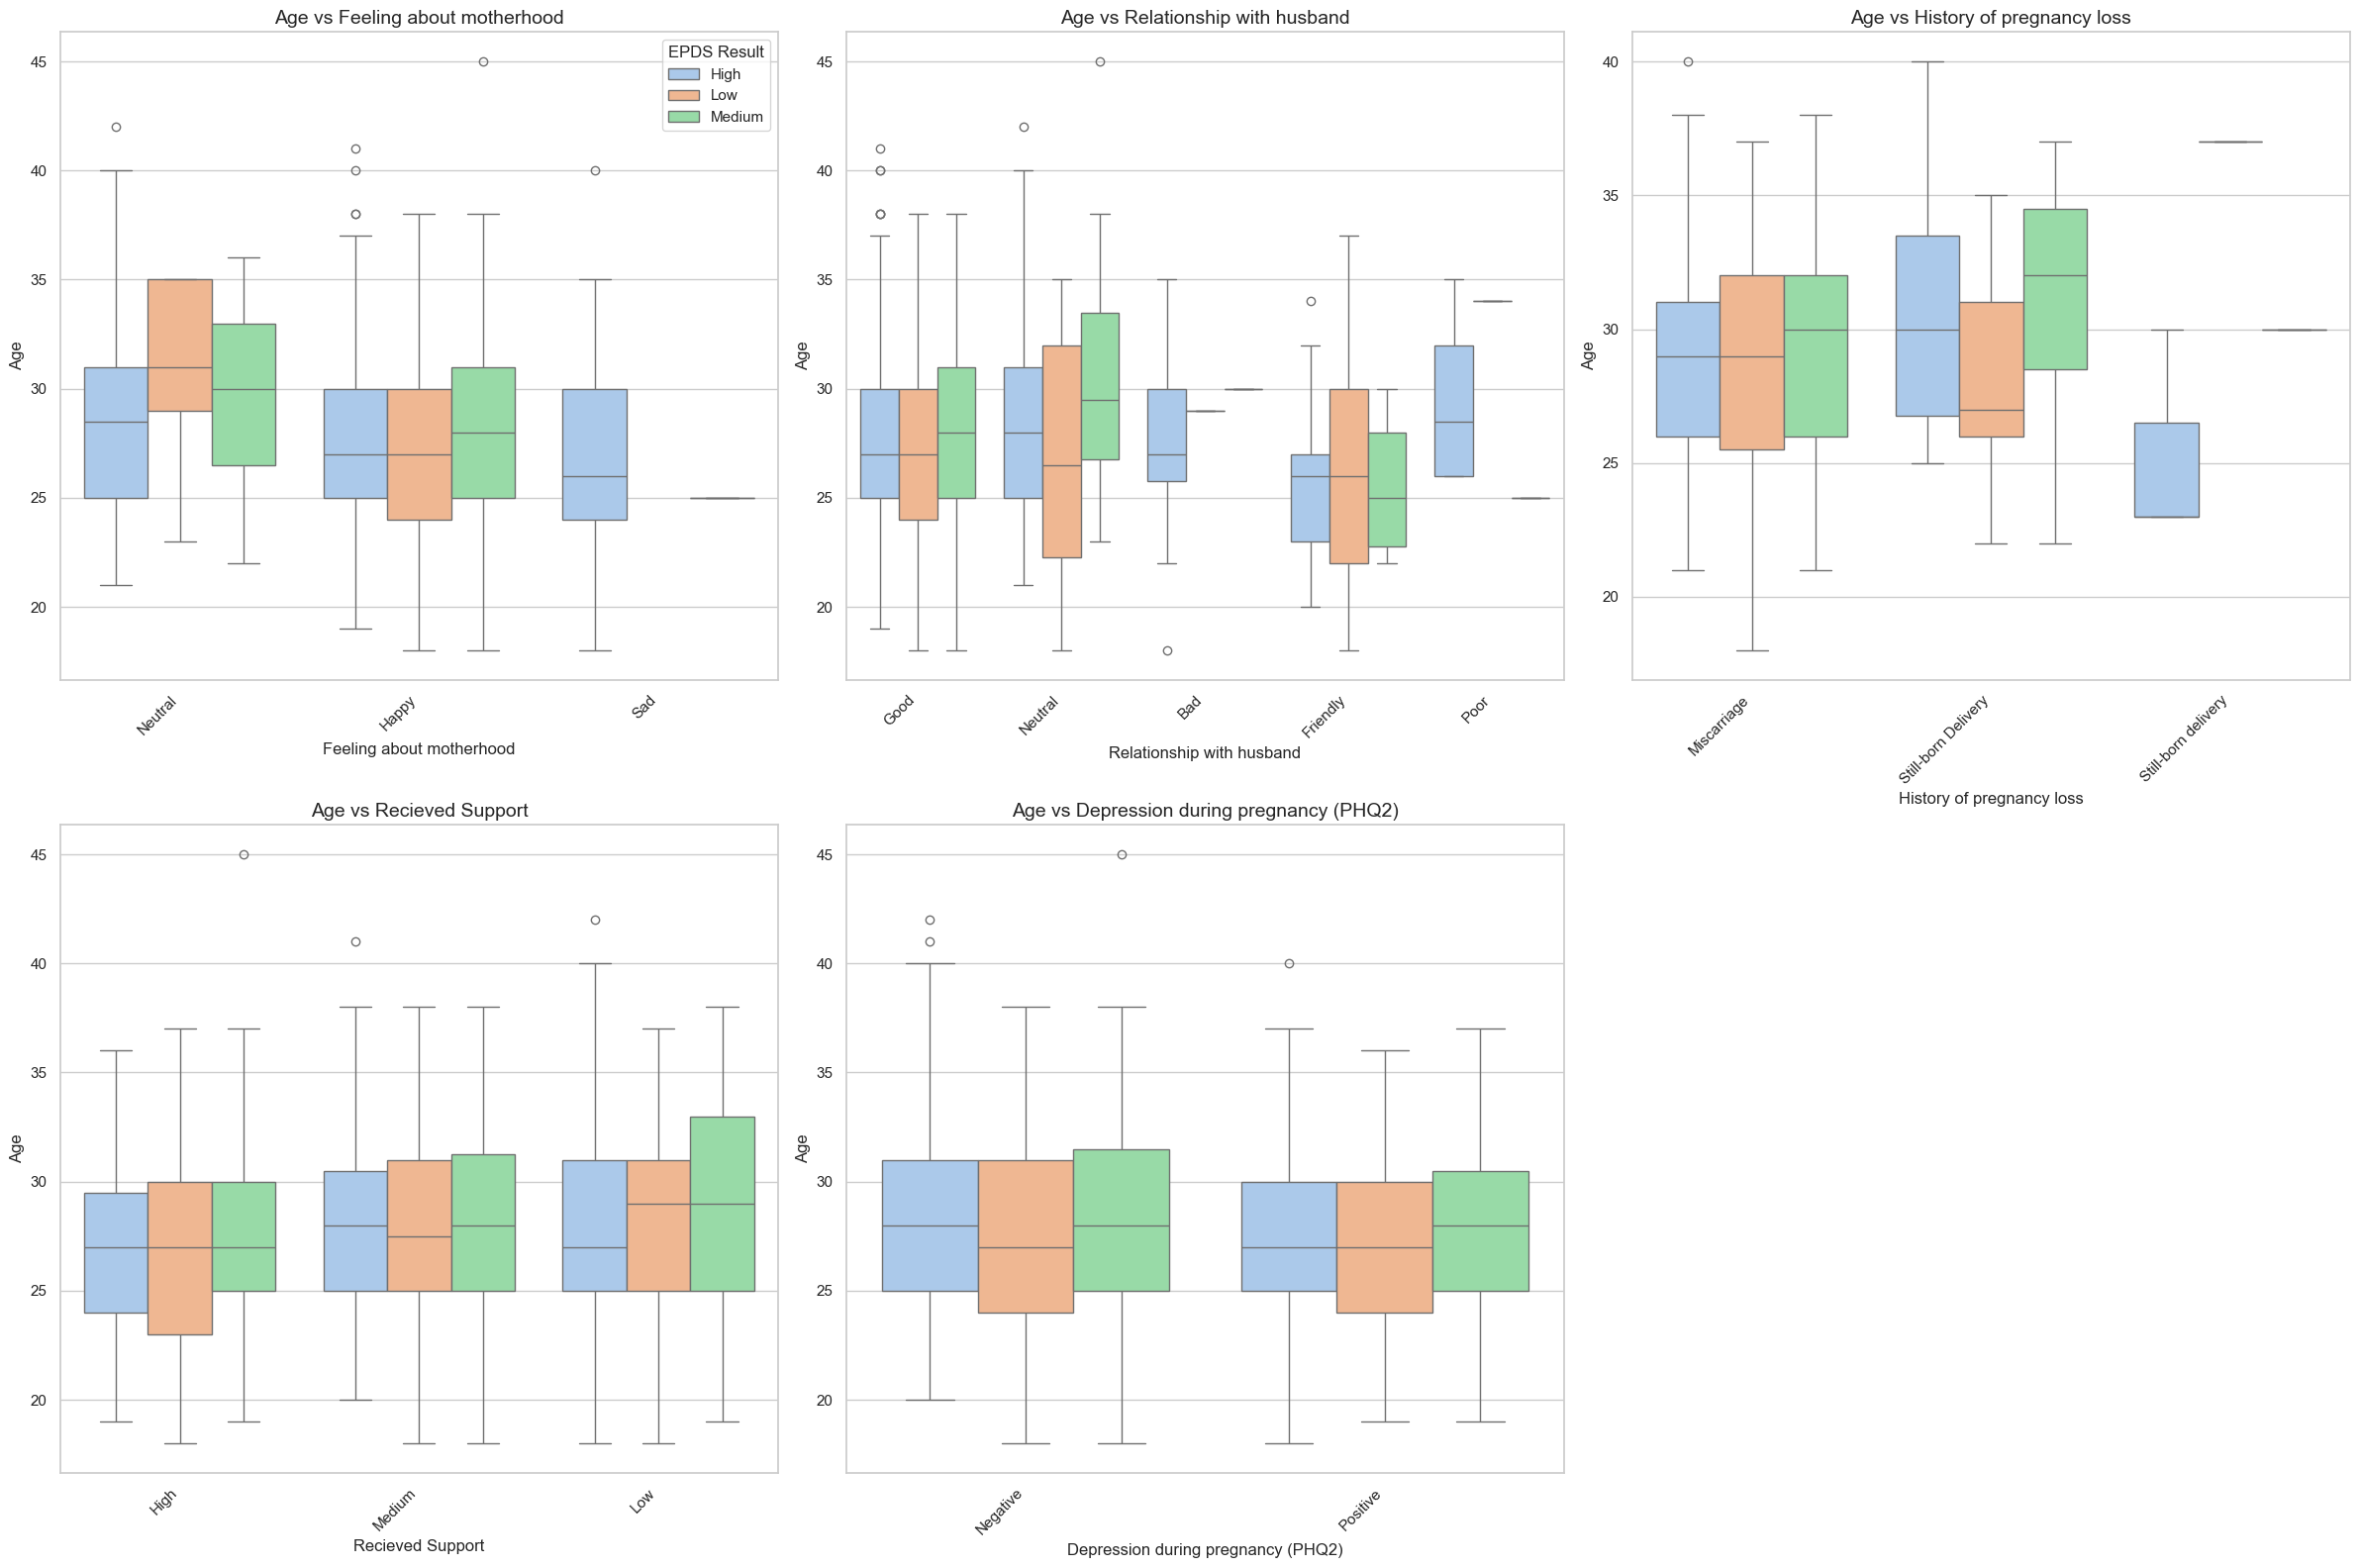

Analyzing 'Number of the latest pregnancy' vs 


,count,mean,std,min,25%,50%,75%,max
Feeling about motherhood,,,,,,,,
Happy,671.0,1.609538,0.867058,1.0,1.0,1.0,2.0,7.0
Neutral,94.0,1.819149,1.057109,1.0,1.0,1.5,2.0,5.0
Sad,35.0,1.542857,0.918530,1.0,1.0,1.0,2.0,5.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Relationship with husband,,,,,,,,
Bad,51.0,1.392157,0.602609,1.0,1.0,1.0,2.00,3.0
Friendly,52.0,1.500000,0.779643,1.0,1.0,1.0,2.00,4.0
Good,578.0,1.648789,0.911798,1.0,1.0,1.0,2.00,7.0
Neutral,113.0,1.716814,0.958692,1.0,1.0,1.0,2.00,6.0
Poor,6.0,1.500000,0.836660,1.0,1.0,1.0,1.75,3.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
History of pregnancy loss,,,,,,,,
Miscarriage,158.0,2.291139,1.048528,1.0,2.0,2.0,3.0,7.0
Still-born Delivery,24.0,3.041667,1.488482,1.0,2.0,2.5,4.0,6.0
Still-born delivery,5.0,2.400000,0.547723,2.0,2.0,2.0,3.0,3.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Recieved Support,,,,,,,,
High,307.0,1.511401,0.809886,1.0,1.0,1.0,2.0,7.0
Low,154.0,1.792208,1.045847,1.0,1.0,2.0,2.0,6.0
Medium,339.0,1.666667,0.882662,1.0,1.0,1.0,2.0,7.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Depression during pregnancy (PHQ2),,,,,,,,
Negative,616.0,1.584416,0.858824,1.0,1.0,1.0,2.0,7.0
Positive,184.0,1.788043,0.993789,1.0,1.0,1.5,2.0,6.0



----------------------------------------------------------------------------------------------------



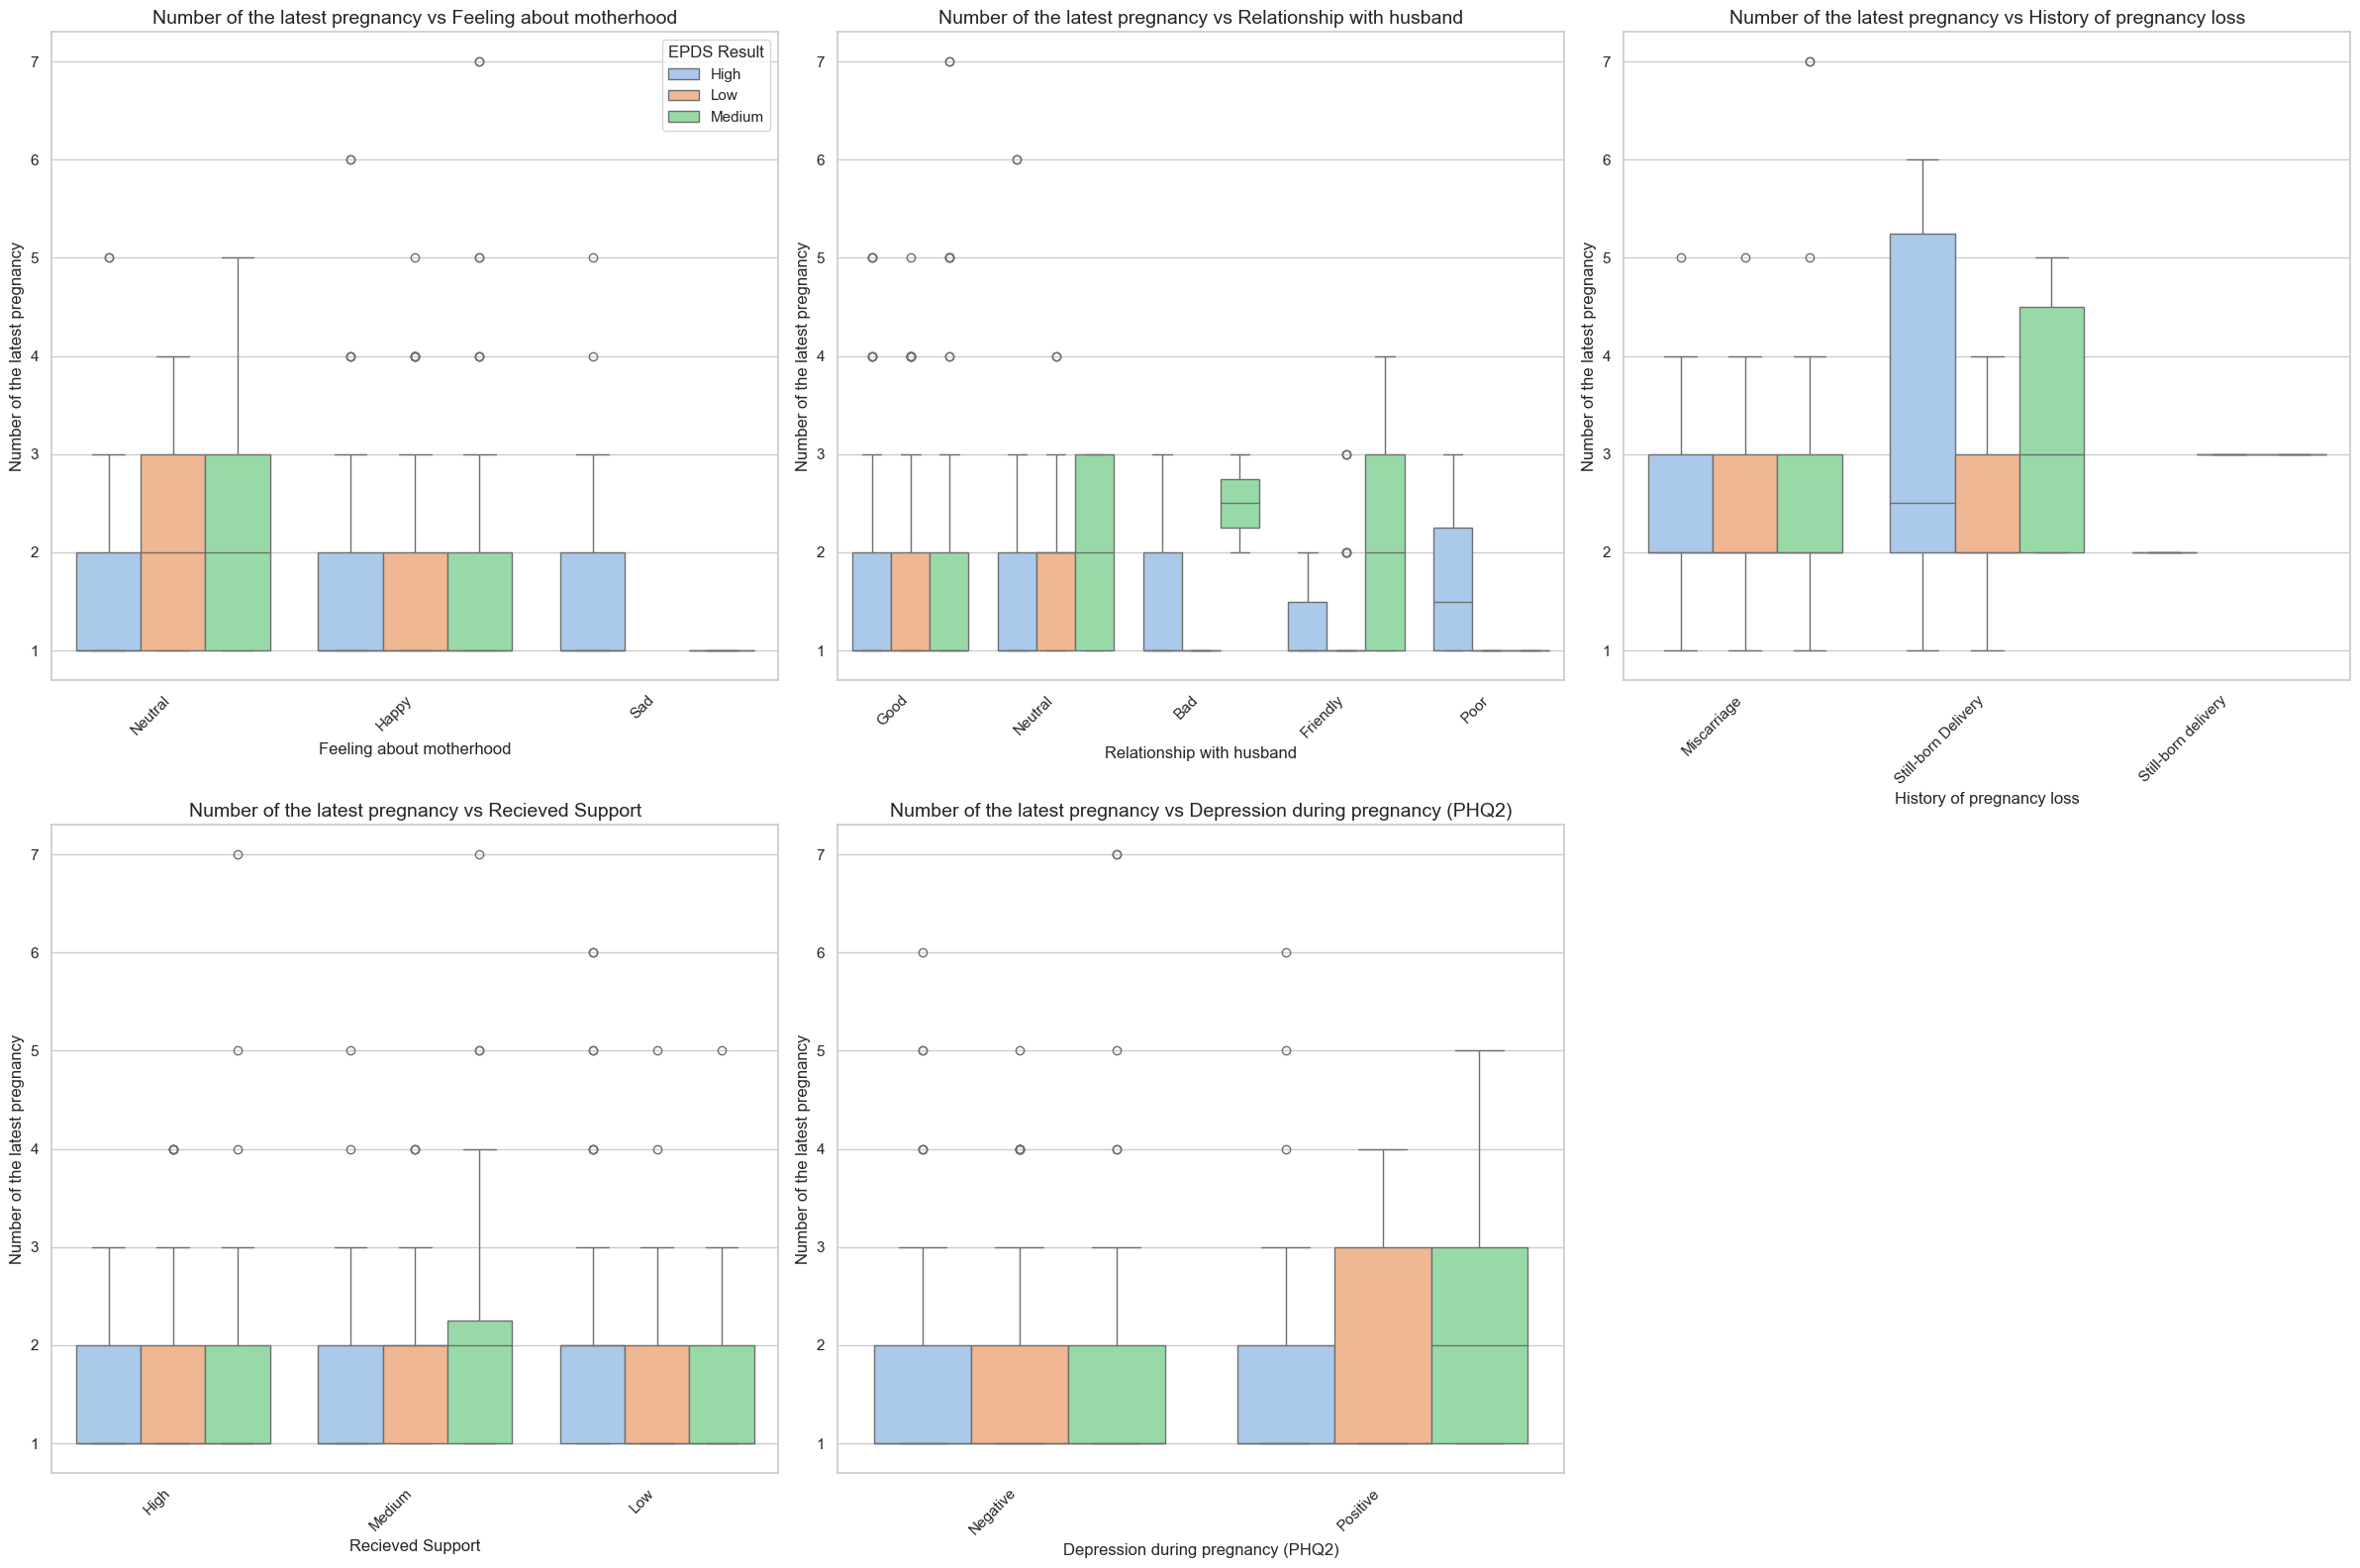

Analyzing 'PHQ9 Score' vs 


,count,mean,std,min,25%,50%,75%,max
Feeling about motherhood,,,,,,,,
Happy,671.0,10.426230,5.332818,0.0,6.0,10.0,14.0,25.0
Neutral,94.0,14.797872,5.782026,5.0,10.0,14.0,20.0,27.0
Sad,35.0,18.828571,4.817161,11.0,14.0,20.0,22.5,27.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Relationship with husband,,,,,,,,
Bad,51.0,18.352941,5.117904,7.0,15.0,18.0,22.50,27.0
Friendly,52.0,8.423077,4.064896,2.0,5.0,8.0,10.25,20.0
Good,578.0,10.610727,5.520627,0.0,6.0,10.0,14.00,27.0
Neutral,113.0,12.778761,5.243592,2.0,9.0,12.0,17.00,24.0
Poor,6.0,15.833333,5.810909,7.0,12.5,17.0,20.00,22.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
History of pregnancy loss,,,,,,,,
Miscarriage,158.0,11.556962,5.750097,0.0,7.0,11.0,15.00,27.0
Still-born Delivery,24.0,9.750000,4.522889,1.0,5.0,10.5,13.25,17.0
Still-born delivery,5.0,10.600000,4.393177,4.0,9.0,11.0,14.00,15.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Recieved Support,,,,,,,,
High,307.0,9.459283,5.261229,0.0,6.0,8.0,13.0,25.0
Low,154.0,12.487013,6.143424,1.0,8.0,12.0,16.0,27.0
Medium,339.0,12.445428,5.613735,0.0,8.0,12.0,16.0,27.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Depression during pregnancy (PHQ2),,,,,,,,
Negative,616.0,10.577922,5.588644,0.0,6.0,10.0,14.0,27.0
Positive,184.0,13.750000,5.709019,1.0,9.0,13.0,18.0,27.0



----------------------------------------------------------------------------------------------------



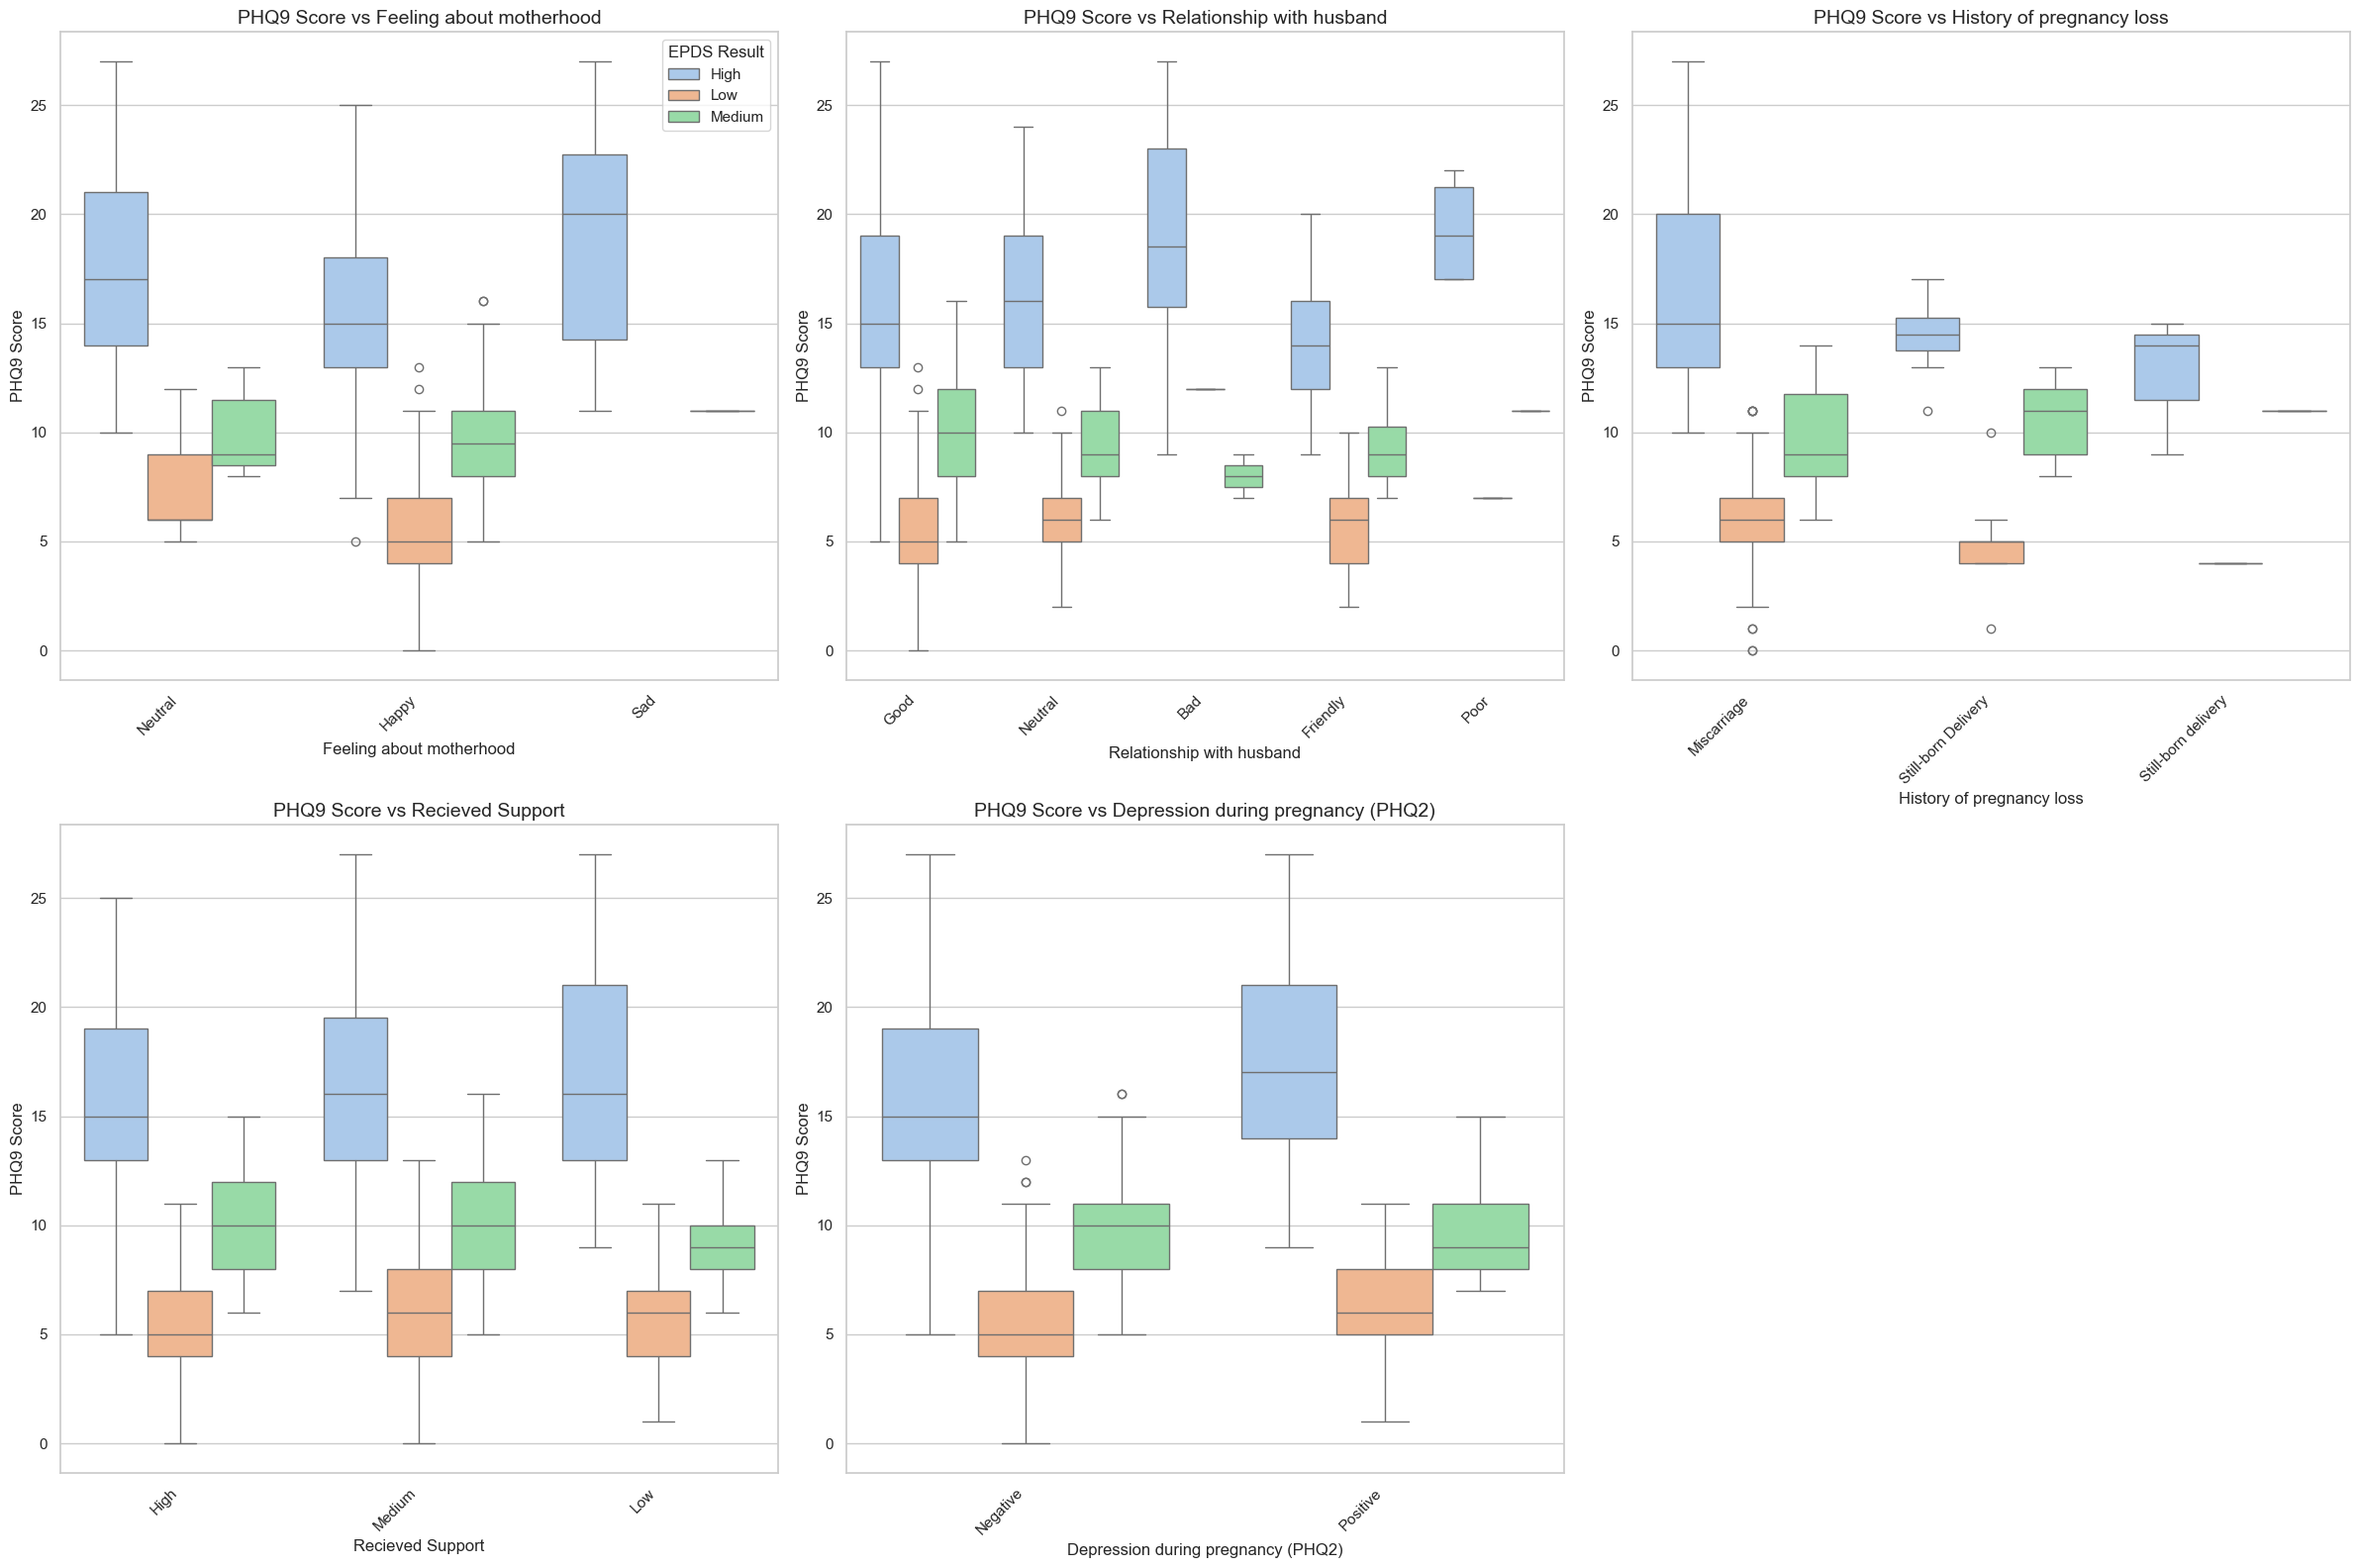

Analyzing 'EPDS Score' vs 


,count,mean,std,min,25%,50%,75%,max
Feeling about motherhood,,,,,,,,
Happy,671.0,11.347243,6.533506,0.0,7.0,10.0,15.00,30.0
Neutral,94.0,16.734043,7.085007,3.0,11.0,17.0,22.75,30.0
Sad,35.0,22.371429,5.423726,10.0,19.0,23.0,26.50,30.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Relationship with husband,,,,,,,,
Bad,51.0,22.235294,5.591380,8.0,19.0,23.0,27.0,30.0
Friendly,52.0,9.076923,5.268650,0.0,5.0,8.0,12.0,26.0
Good,578.0,11.442907,6.642729,0.0,7.0,11.0,15.0,30.0
Neutral,113.0,14.584071,6.577458,2.0,9.0,14.0,20.0,30.0
Poor,6.0,17.000000,7.348469,7.0,12.0,18.5,20.5,27.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
History of pregnancy loss,,,,,,,,
Miscarriage,158.0,12.759494,7.152061,0.0,8.00,12.0,17.00,30.0
Still-born Delivery,24.0,9.791667,6.426705,0.0,3.75,10.5,13.25,25.0
Still-born delivery,5.0,12.400000,5.727128,3.0,12.00,13.0,17.00,17.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Recieved Support,,,,,,,,
High,307.0,9.915309,6.387743,0.0,5.0,9.0,13.00,30.0
Low,154.0,14.194805,7.578847,0.0,8.0,13.0,20.75,30.0
Medium,339.0,13.982301,6.824923,0.0,9.0,13.0,19.00,30.0



----------------------------------------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Depression during pregnancy (PHQ2),,,,,,,,
Negative,616.0,11.538961,6.884301,0.0,6.0,11.0,16.0,30.0
Positive,184.0,15.554348,6.943746,0.0,10.0,14.0,21.0,30.0



----------------------------------------------------------------------------------------------------



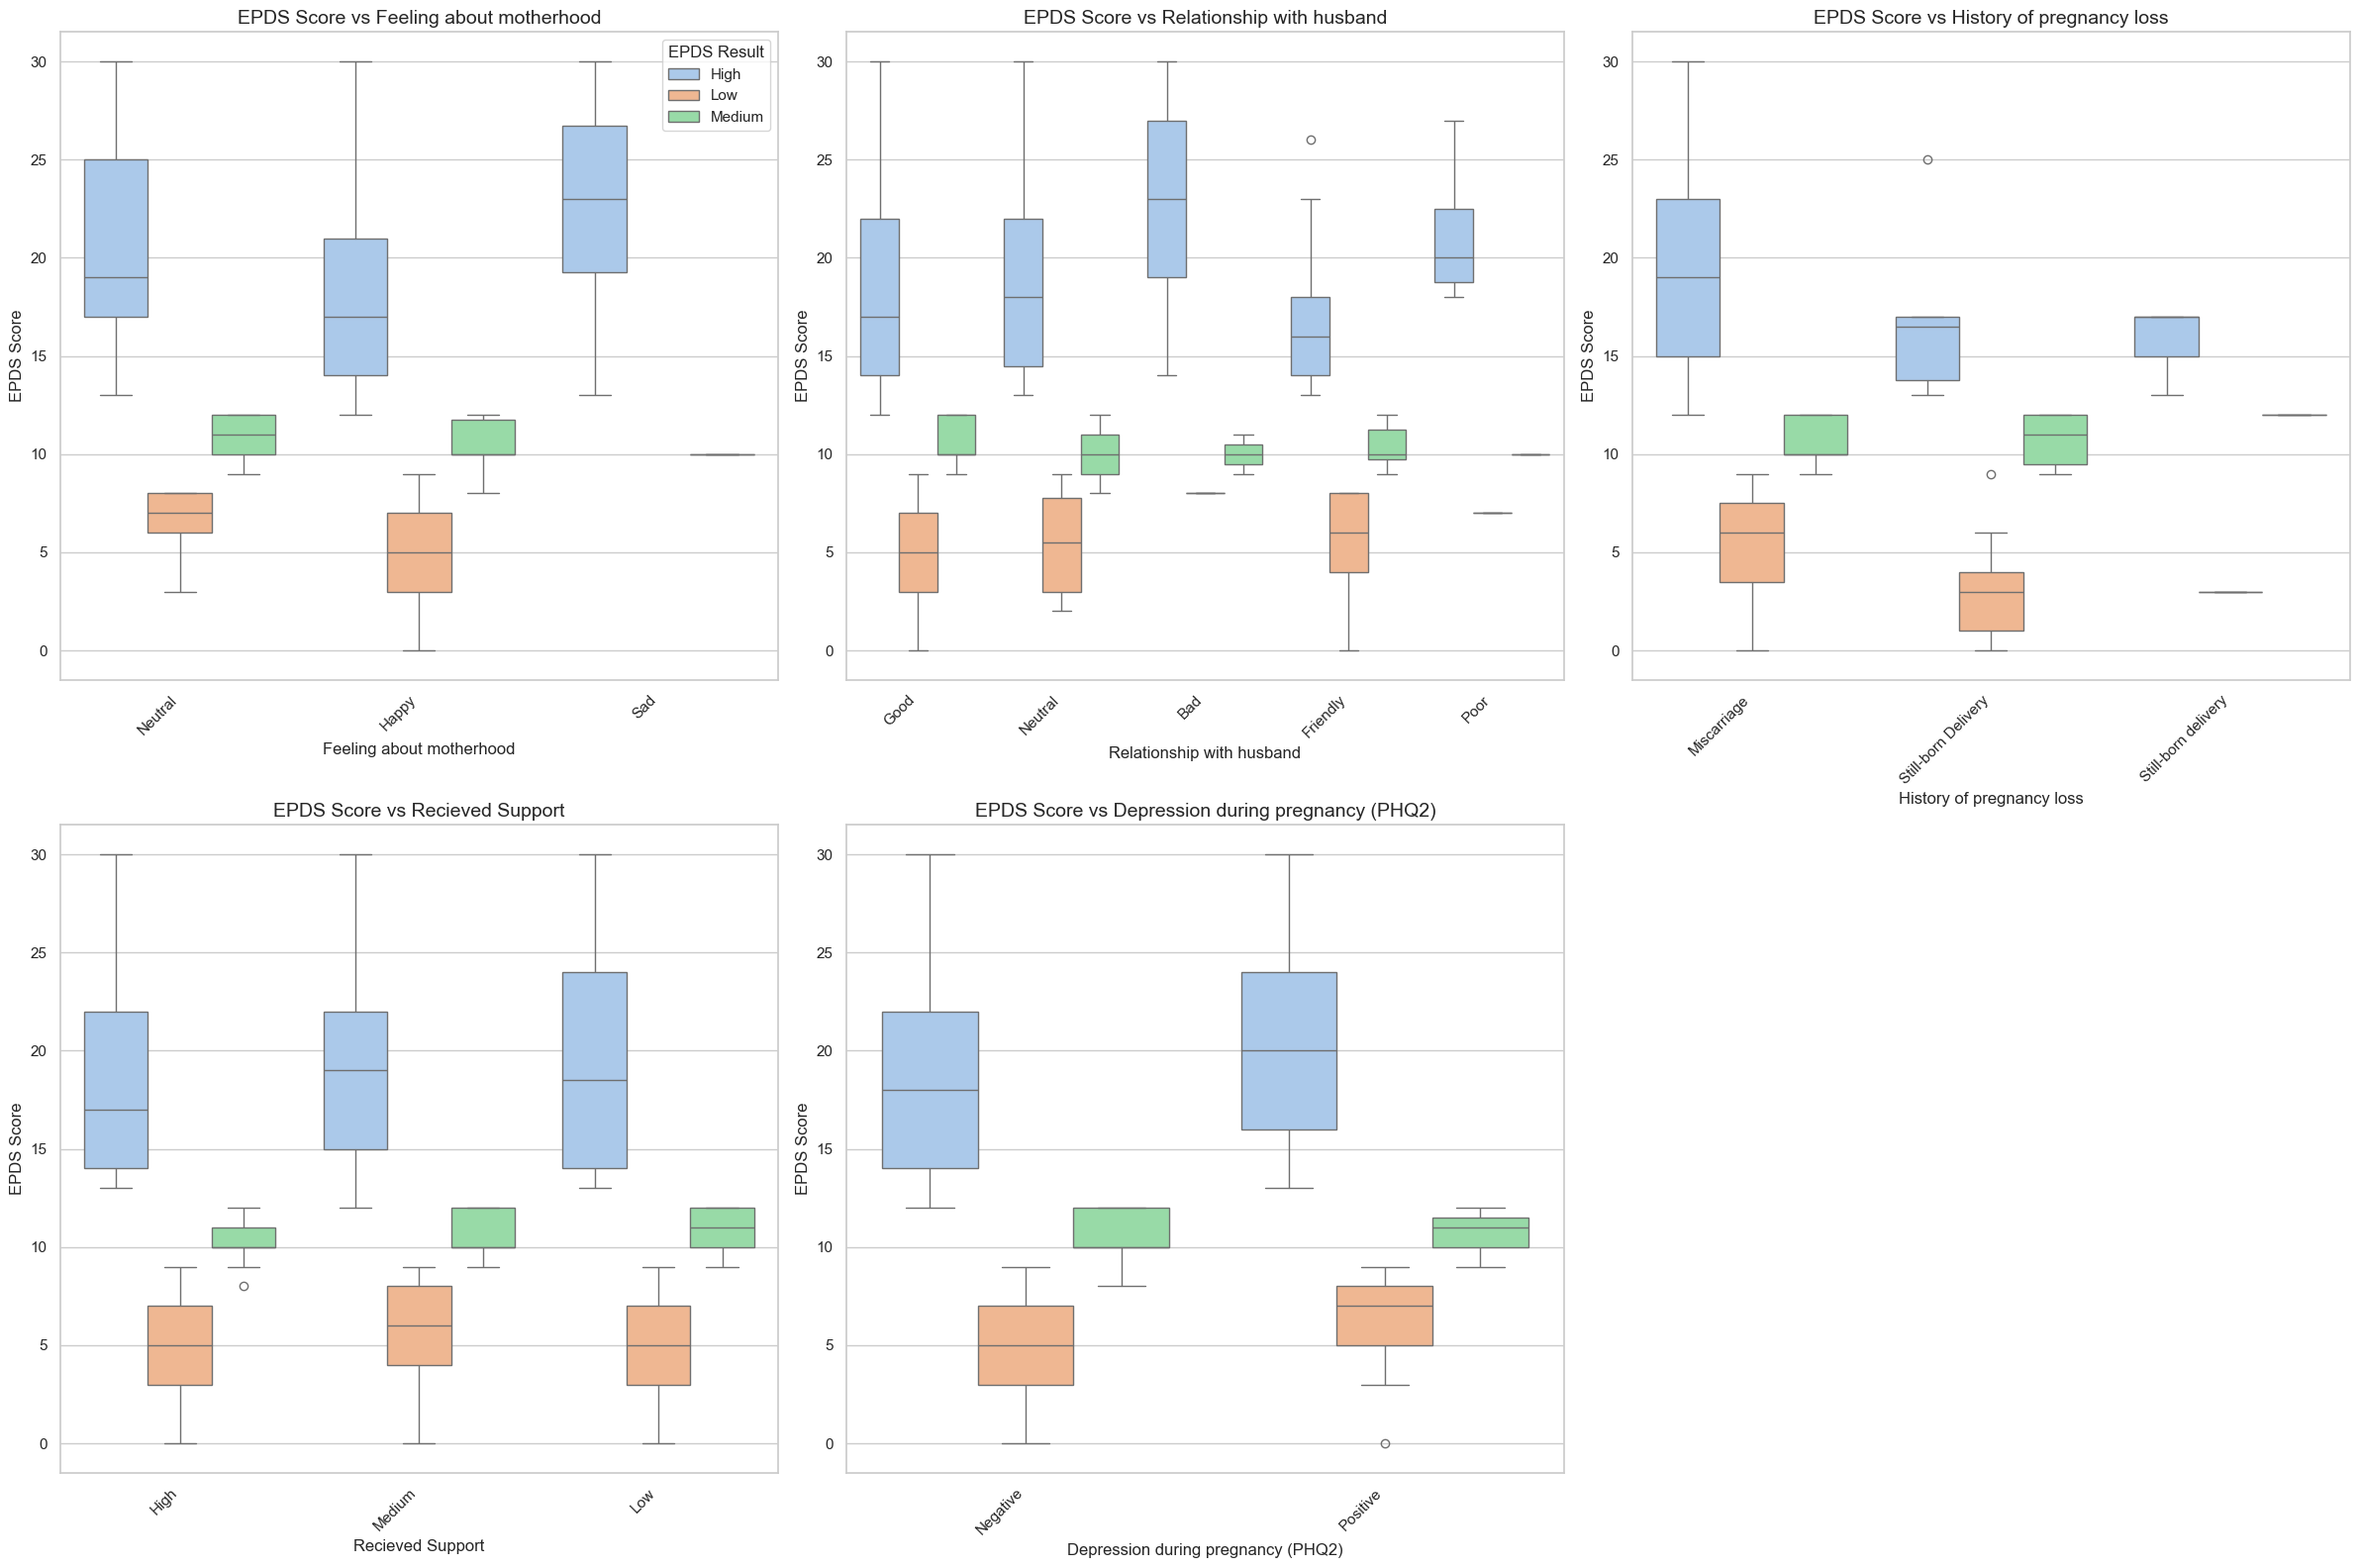

In [33]:
# --- Categorical vs Numerical analysis for PPD (big square layout, no duplicates) ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']

for num_col in numeric_cols:
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # 2 rows x 3 columns
    axes = axes.flatten()
    
    print(f"Analyzing '{num_col}' vs ")
    for i, cat_col in enumerate(top5_cat):
        ax = axes[i]
        
        # Boxplot: numeric vs categorical
        sns.boxplot(data=df, x=cat_col, y=num_col, hue='EPDS Result', ax=ax, palette='pastel')
        
        # Titles and labels
        ax.set_title(f"{num_col} vs {cat_col}", fontsize=14)
        ax.set_xlabel(cat_col, fontsize=12)
        ax.set_ylabel(num_col, fontsize=12)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.tick_params(axis='y', labelsize=11)
        
        # Legend only for first subplot
        if i != 0:
            ax.get_legend().remove()
        else:
            ax.legend(title='EPDS Result', fontsize=11, title_fontsize=12)
        
        # --- Summary statistics (one print per numeric x categorical pair) ---
        display(df.groupby(cat_col)[num_col].describe())
        print("\n" + "-"*100 + "\n")
    
    # Remove any empty subplot (6th subplot in 2x3 grid)
    if len(top5_cat) < len(axes):
        for j in range(len(top5_cat), len(axes)):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


## Numerical vs Numerical pair plot


<Figure size 1200x1200 with 0 Axes>

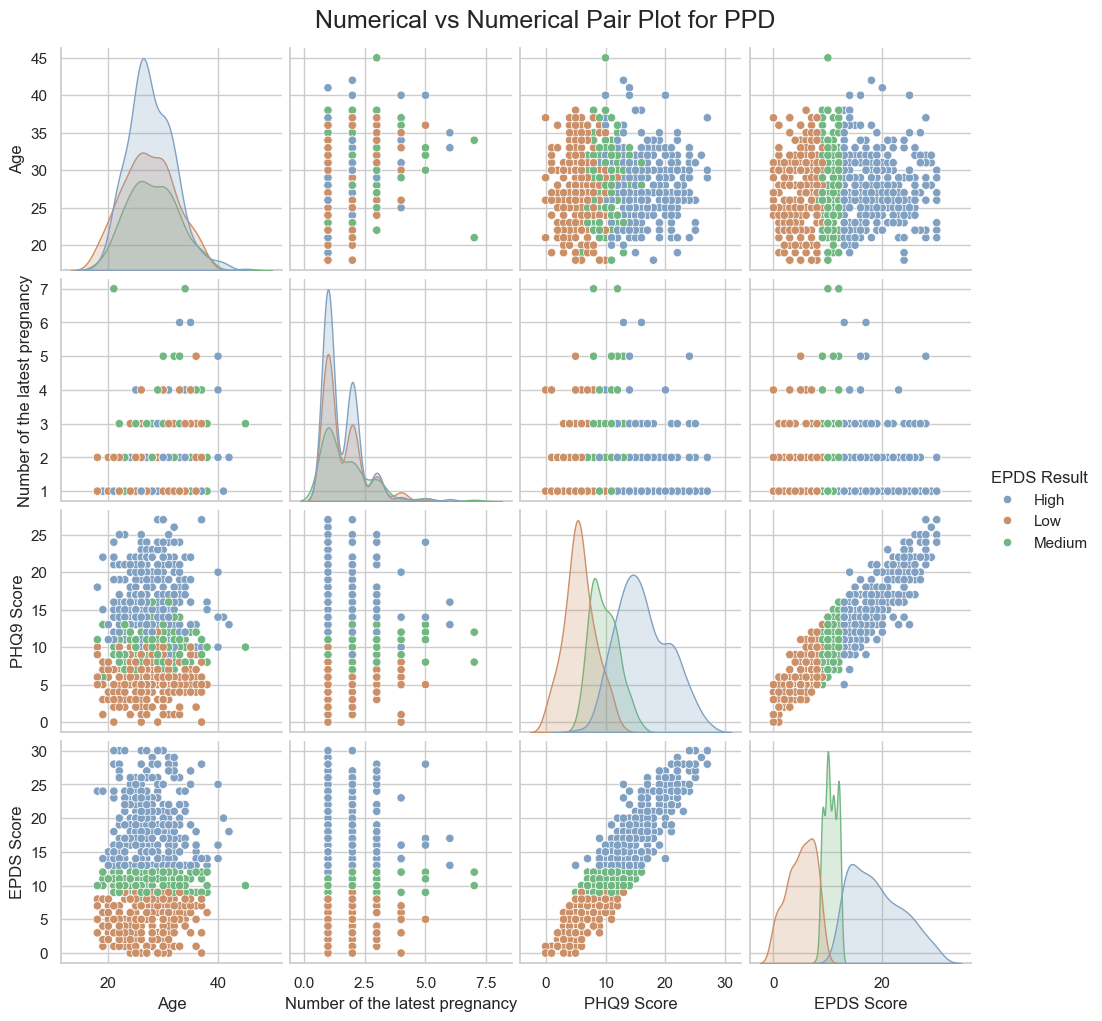

In [34]:
# --- Numerical vs Numerical analysis for PPD (darker pastel) ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
target_col = 'EPDS Result'

# Create slightly darker pastel palette
n_classes = df[target_col].nunique()
base_palette = sns.color_palette("pastel", n_colors=n_classes)
darker_palette = [(r*0.8, g*0.8, b*0.8) for r, g, b in base_palette]

# Pairplot with hue = EPDS Result
plt.figure(figsize=(12, 12))
sns.pairplot(df[numeric_cols + [target_col]], 
             hue=target_col, 
             palette=darker_palette,  # darker pastel
             diag_kind='kde', 
             corner=False)  # corner=False shows full matrix

plt.suptitle("Numerical vs Numerical Pair Plot for PPD", fontsize=18, y=1.02)
plt.show()


## Missing data handling strategy
1. Show missing % per column.  
2. Impute numeric columns with median (configurable).  
3. Impute categorical with mode or 'missing' label.  
4. Optionally use KNNImputer for more advanced imputation (not included by default).


In [35]:
# --- Strip leading/trailing spaces from column names ---
df.columns = df.columns.str.strip()
cat_cols = [c.strip() for c in cat_cols]
num_cols = [c.strip() for c in num_cols if c.strip() != 'sr']  # remove 'sr'

# --- Missing values BEFORE imputation (using same approach as before) ---
missing_before = df.isnull().sum().sort_values(ascending=False)
missing_before = missing_before[missing_before > 0]

missing_before_df = pd.DataFrame({
    'Features': missing_before.index,
    'Missing Count (Before)': missing_before.values,
    'Missing % (Before)': round((missing_before / len(df)) * 100, 2).values
}).reset_index(drop=True)

# --- Copy dataframe for preprocessing ---
df_proc = df.copy()

# --- Numeric imputation ---
use_knn = False  # Set True to use KNN imputer, False to use median

if len(num_cols) > 0:
    if use_knn:
        knn_imputer = KNNImputer(n_neighbors=5)
        df_proc[num_cols] = knn_imputer.fit_transform(df_proc[num_cols])
    else:
        num_imputer = SimpleImputer(strategy='median')
        df_proc[num_cols] = num_imputer.fit_transform(df_proc[num_cols])

# --- Categorical imputation ---
for c in cat_cols:
    df_proc[c] = df_proc[c].fillna('Missing')

# --- Missing values AFTER imputation (same columns as before) ---
missing_after = df_proc[missing_before.index].isnull().sum()
missing_after_df = pd.DataFrame({
    'Features': missing_after.index,
    'Missing Count (After)': missing_after.values,
    'Missing % (After)': round((missing_after / len(df_proc)) * 100, 2).values
}).reset_index(drop=True)

# --- Combined table: Before vs After ---
missing_summary = pd.concat([
    missing_before_df[['Features', 'Missing Count (Before)', 'Missing % (Before)']],
    missing_after_df[['Missing Count (After)', 'Missing % (After)']]
], axis=1)

print("Missing Data Handling: Before vs After Imputation")
display(missing_summary)



Missing Data Handling: Before vs After Imputation


,Features,Missing Count (Before),Missing % (Before),Missing Count (After),Missing % (After)
0,Addiction,789,98.62,0,0.0
1,History of pregnancy loss,613,76.62,0,0.0
2,Disease before pregnancy,589,73.62,0,0.0
3,Current monthly income,525,65.62,0,0.0
4,Age of immediate older children,517,64.62,0,0.0
5,Monthly income before latest pregnancy,437,54.62,0,0.0
6,Diseases during pregnancy,371,46.38,0,0.0
7,Feeling for regular activities,223,27.88,0,0.0
8,Need for Support,167,20.88,0,0.0
9,Abuse,38,4.75,0,0.0


## Stratified sampling
We will split data into train/test preserving the target distribution using `stratify=y`.  
**Important:** set `target_col` to the actual target variable name in your dataset.


In [36]:
# --- Target column ---
target_col = 'EPDS Result'   # <-- replace if needed

if target_col not in df_proc.columns:
    raise ValueError(f"Target column '{target_col}' not found. Update target_col variable.")

# Features & target
X = df_proc.drop(columns=[target_col])
y = df_proc[target_col]

# Original class distribution
print("Original class distribution:")
display(Counter(y))

# --- Stratified train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% test
    random_state=42,
    stratify=y           # preserves class distribution
)

# Verify class distribution
print("\nTrain class distribution:")
display(Counter(y_train))
print("\nTest class distribution:")
display(Counter(y_test))



Original class distribution:


Counter({'High': 350, 'Low': 260, 'Medium': 190})


Train class distribution:


Counter({'High': 280, 'Low': 208, 'Medium': 152})


Test class distribution:


Counter({'High': 70, 'Low': 52, 'Medium': 38})

## One-Hot Encoding


In [37]:
# --- Identify categorical columns to encode ---
cat_cols_to_encode = [c for c in X_train.columns if c in cat_cols]

print(f"Categorical columns to encode ({len(cat_cols_to_encode)}): {cat_cols_to_encode}")

# --- One-hot encoder (handle unknown categories in test set) ---
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training data
X_train_encoded = ohe.fit_transform(X_train[cat_cols_to_encode])
X_test_encoded = ohe.transform(X_test[cat_cols_to_encode])

# Column names after encoding
encoded_cols = ohe.get_feature_names_out(cat_cols_to_encode)

# Convert to DataFrame
X_train_ohe = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# --- Drop original categorical columns and append encoded ones ---
X_train_final = pd.concat([X_train.drop(columns=cat_cols_to_encode), X_train_ohe], axis=1)
X_test_final  = pd.concat([X_test.drop(columns=cat_cols_to_encode), X_test_ohe], axis=1)

print("Training set shape after one-hot encoding:", X_train_final.shape)
print("Test set shape after one-hot encoding:", X_test_final.shape)

print("\n--- Sample of One-Hot Encoded Features (first 5 rows) ---")
print(f"Number of one-hot encoded columns: {len(encoded_cols)}")
display(X_train_ohe.head())

print("\n--- One-Hot Encoded Feature Names ---")
print(f"Total encoded features: {len(encoded_cols)}")
print("All encoded column names:")
import textwrap
col_list_str = ', '.join(encoded_cols)
wrapped_cols = textwrap.fill(col_list_str, width=120)
print(wrapped_cols)



Categorical columns to encode (45): ['Residence', 'Education Level', 'Marital status', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'Occupation After Your Latest Childbirth', 'Current monthly income', "Husband's education level", "Husband's monthly income", 'Addiction', 'Total children', 'Disease before pregnancy', 'History of pregnancy loss', 'Family type', 'Number of household members', 'Relationship with the in-laws', 'Relationship with husband', 'Relationship with the newborn', 'Relationship between father and newborn', 'Feeling about motherhood', 'Recieved Support', 'Need for Support', 'Major changes or losses during pregnancy', 'Abuse', 'Trust and share feelings', 'Pregnancy length', 'Pregnancy plan', 'Regular checkups', 'Fear of pregnancy', 'Diseases during pregnancy', 'Age of newborn', 'Age of immediate older children', 'Mode of delivery', 'Gender of newborn', 'Birth compliancy', 'Breastfeed', 'Newborn illness', 'Worry about newborn', 'Relax/s

,Residence_City,Residence_Village,Education Level_College,Education Level_High School,Education Level_High school,Education Level_Missing,Education Level_Primary School,Education Level_Primary school,Education Level_University,Marital status_Divorced,Marital status_Married,Occupation before latest pregnancy_Business,Occupation before latest pregnancy_Doctor,Occupation before latest pregnancy_House wife,Occupation before latest pregnancy_Housewife,Occupation before latest pregnancy_Other,Occupation before latest pregnancy_Service,Occupation before latest pregnancy_Student,Occupation before latest pregnancy_Teacher,Monthly income before latest pregnancy_10000 to 20000,Monthly income before latest pregnancy_20000 to 30000,Monthly income before latest pregnancy_5000 to 10000,Monthly income before latest pregnancy_Less than 5000,Monthly income before latest pregnancy_Missing,Monthly income before latest pregnancy_More than 30000,Occupation After Your Latest Childbirth_Business,Occupation After Your Latest Childbirth_Doctor,Occupation After Your Latest Childbirth_House wife,Occupation After Your Latest Childbirth_Housewife,Occupation After Your Latest Childbirth_Other,Occupation After Your Latest Childbirth_Service,Occupation After Your Latest Childbirth_Student,Occupation After Your Latest Childbirth_Teacher,Current monthly income_10000 to 20000,Current monthly income_20000 to 30000,Current monthly income_5000 to 10000,Current monthly income_Less than 5000,Current monthly income_Missing,Current monthly income_More than 30000,Husband's education level_College,Husband's education level_High School,Husband's education level_High school,Husband's education level_Missing,Husband's education level_Primary School,Husband's education level_Primary school,Husband's education level_University,Husband's monthly income_10000 to 20000,Husband's monthly income_20000 to 30000,Husband's monthly income_5000 to 10000,Husband's monthly income_Less than 5000,Husband's monthly income_Missing,Husband's monthly income_More than 30000,Addiction_Drinking,Addiction_Drugs,Addiction_Missing,Addiction_Smoking,Total children_More than Two,Total children_More than two,Total children_One,Total children_Two,Disease before pregnancy_Chronic Disease,Disease before pregnancy_Missing,Disease before pregnancy_Non-Chronic Disease,History of pregnancy loss_Miscarriage,History of pregnancy loss_Missing,History of pregnancy loss_Still-born Delivery,History of pregnancy loss_Still-born delivery,Family type_Joint,Family type_Nuclear,Number of household members_2 to 5,Number of household members_6 to 8,Number of household members_9 or more,Relationship with the in-laws_Bad,Relationship with the in-laws_Friendly,Relationship with the in-laws_Good,Relationship with the in-laws_Neutral,Relationship with the in-laws_Poor,Relationship with husband_Bad,Relationship with husband_Friendly,Relationship with husband_Good,Relationship with husband_Neutral,Relationship with husband_Poor,Relationship with the newborn_Bad,Relationship with the newborn_Good,Relationship with the newborn_Neutral,Relationship with the newborn_Very good,Relationship between father and newborn_Bad,Relationship between father and newborn_Good,Relationship between father and newborn_Neutral,Relationship between father and newborn_Very good,Feeling about motherhood_Happy,Feeling about motherhood_Neutral,Feeling about motherhood_Sad,Recieved Support_High,Recieved Support_Low,Recieved Support_Medium,Need for Support_High,Need for Support_Low,Need for Support_Medium,Need for Support_Missing,Major changes or losses during pregnancy_No,Major changes or losses during pregnancy_Yes,Abuse_Missing,Abuse_No,Abuse_Yes,Trust and share feelings_Missing,Trust and share feelings_No,Trust and share feelings_Yes,Pregnancy length_10 months,Pregnancy length_6 months,Pregnancy length_7 months,Pregnancy length_8 months,Pregnancy length_9 months,Pregnancy length_Less than 5 months,Pregnancy plan_No,Pregnancy plan_Yes,Regular checkups_N


--- One-Hot Encoded Feature Names ---
Total encoded features: 166
All encoded column names:
Residence_City, Residence_Village, Education Level_College, Education Level_High School, Education Level_High school,
Education Level_Missing, Education Level_Primary School, Education Level_Primary school, Education Level_University,
Marital status_Divorced, Marital status_Married, Occupation before latest pregnancy_Business, Occupation before latest
pregnancy_Doctor, Occupation before latest pregnancy_House wife, Occupation before latest pregnancy_Housewife,
Occupation before latest pregnancy_Other, Occupation before latest pregnancy_Service, Occupation before latest
pregnancy_Student, Occupation before latest pregnancy_Teacher, Monthly income before latest pregnancy_10000 to 20000,
Monthly income before latest pregnancy_20000 to 30000, Monthly income before latest pregnancy_5000 to 10000, Monthly
income before latest pregnancy_Less than 5000, Monthly income before latest pregnancy_Missing, M

##  Standardization
We will StandardScale numeric features: ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']

In [38]:
# Numeric columns to scale
num_cols_to_scale = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']

# --- Separate numeric data ---
X_train_num = X_train[num_cols_to_scale].copy()
X_test_num  = X_test[num_cols_to_scale].copy()

# --- Standardization ---
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), 
                           columns=num_cols_to_scale, index=X_train.index)
X_test_num  = pd.DataFrame(scaler.transform(X_test_num), 
                           columns=num_cols_to_scale, index=X_test.index)

# --- Separate categorical (one-hot) columns ---
X_train_cat = X_train_ohe.drop(columns=num_cols_to_scale, errors='ignore')
X_test_cat  = X_test_ohe.drop(columns=num_cols_to_scale, errors='ignore')

# --- Combine numeric + categorical ---
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final  = pd.concat([X_test_num, X_test_cat], axis=1)

# --- Display after standardization ---
print("Training set (first 5 rows) - Standardized Numeric Features:")
display(X_train_num.head())

print("\nTest set (first 5 rows) - Standardized Numeric Features:")
display(X_test_num.head())

print("\nFinal training set shape:", X_train_final.shape)
print("Final test set shape:", X_test_final.shape)



Training set (first 5 rows) - Standardized Numeric Features:


,Age,Number of the latest pregnancy,PHQ9 Score,EPDS Score
480,0.495366,0.399036,-1.089797,-0.905563
230,0.495366,0.399036,0.120488,-0.064401
353,0.938771,-0.706519,-0.398206,-0.204595
400,0.495366,-0.706519,-0.744001,-0.344789
46,-0.834848,-0.706519,-0.225308,-0.905563



Test set (first 5 rows) - Standardized Numeric Features:


,Age,Number of the latest pregnancy,PHQ9 Score,EPDS Score
122,0.717069,-0.706519,0.984978,1.337534
584,1.160474,0.399036,-0.225308,-0.204595
526,-1.278253,-0.706519,-1.089797,-0.765369
140,-0.391443,0.399036,-0.916899,-0.765369
580,-0.391443,0.399036,0.120488,-0.344789



Final training set shape: (640, 170)
Final test set shape: (160, 170)


## Balancing techniques
- SMOTE-NC (synthetic oversampling)


In [39]:
if not has_imblearn:
    print("imbalanced-learn not installed. Install with `pip install imbalanced-learn` to use SMOTE-NC.")
else:
    # Combine numeric and one-hot encoded categorical features for SMOTE-NC
    # X_train has both numeric columns and one-hot encoded categorical columns
    X_tr_combined = X_train_final.values  # Combined numeric + one-hot encoded categorical
    y_tr = y_train.copy()
    
    # Encode target if it's categorical
    if y_tr.dtype == 'O' or y_tr.dtype.name == 'category':
        le = LabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)
        classes = le.classes_
    else:
        y_tr_enc = y_tr.values
        classes = np.unique(y_tr_enc)
    
    print("Original training distribution:", Counter(y_tr))
    
    # Identify categorical feature indices (one-hot encoded columns)
    # One-hot encoded features are binary (0 or 1), all others are numeric
    categorical_indices = [i for i, col in enumerate(X_train_final.columns) if col not in ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']]
    
    print(f"\nNumeric features: {['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']}")
    print(f"One-hot encoded categorical features: {len(categorical_indices)} columns")
    
    # Apply SMOTE-NC (Synthetic Minority Over-sampling Technique for Nominal and Continuous)
    sm = SMOTENC(categorical_features=categorical_indices, random_state=42)
    X_train_bal, y_train_bal_enc = sm.fit_resample(X_tr_combined, y_tr_enc)
    
    # Decode back if target was categorical
    if y_tr.dtype == 'O' or y_tr.dtype.name == 'category':
        y_train_bal = le.inverse_transform(y_train_bal_enc)
    else:
        y_train_bal = y_train_bal_enc
    
    print("\nAfter SMOTE-NC (balanced training set):", Counter(y_train_bal))
    print("X_train_bal shape:", X_train_bal.shape)
    print("y_train_bal shape:", y_train_bal.shape)
    
    # Convert balanced data back to DataFrame for display
    X_train_bal_df = pd.DataFrame(X_train_bal, columns=X_train_final.columns)
    print("\n--- Sample of Features After SMOTE-NC Balancing (first 5 rows) ---")
    display(X_train_bal_df.head())



imbalanced-learn not installed. Install with `pip install imbalanced-learn` to use SMOTE-NC.


## Correlation matrix & feature drop
- Approximate mutual information between features and target (for numeric & categorical).
- Then drop highly collinear features (threshold configurable).


Excluding ID-like columns: []


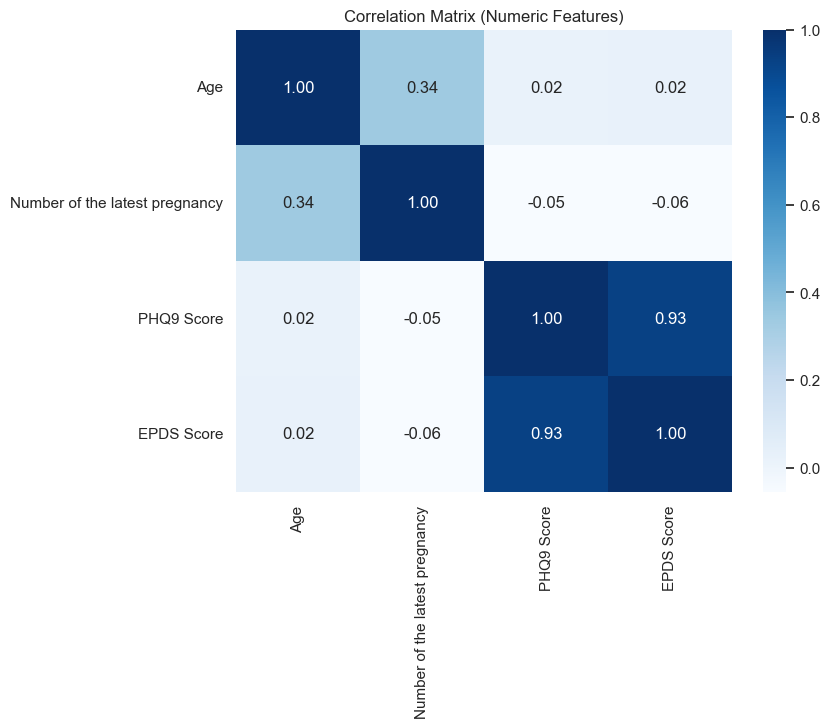

Highly correlated numeric feature pairs (consider dropping one):
PHQ9 Score <--> EPDS Score | corr = 0.93


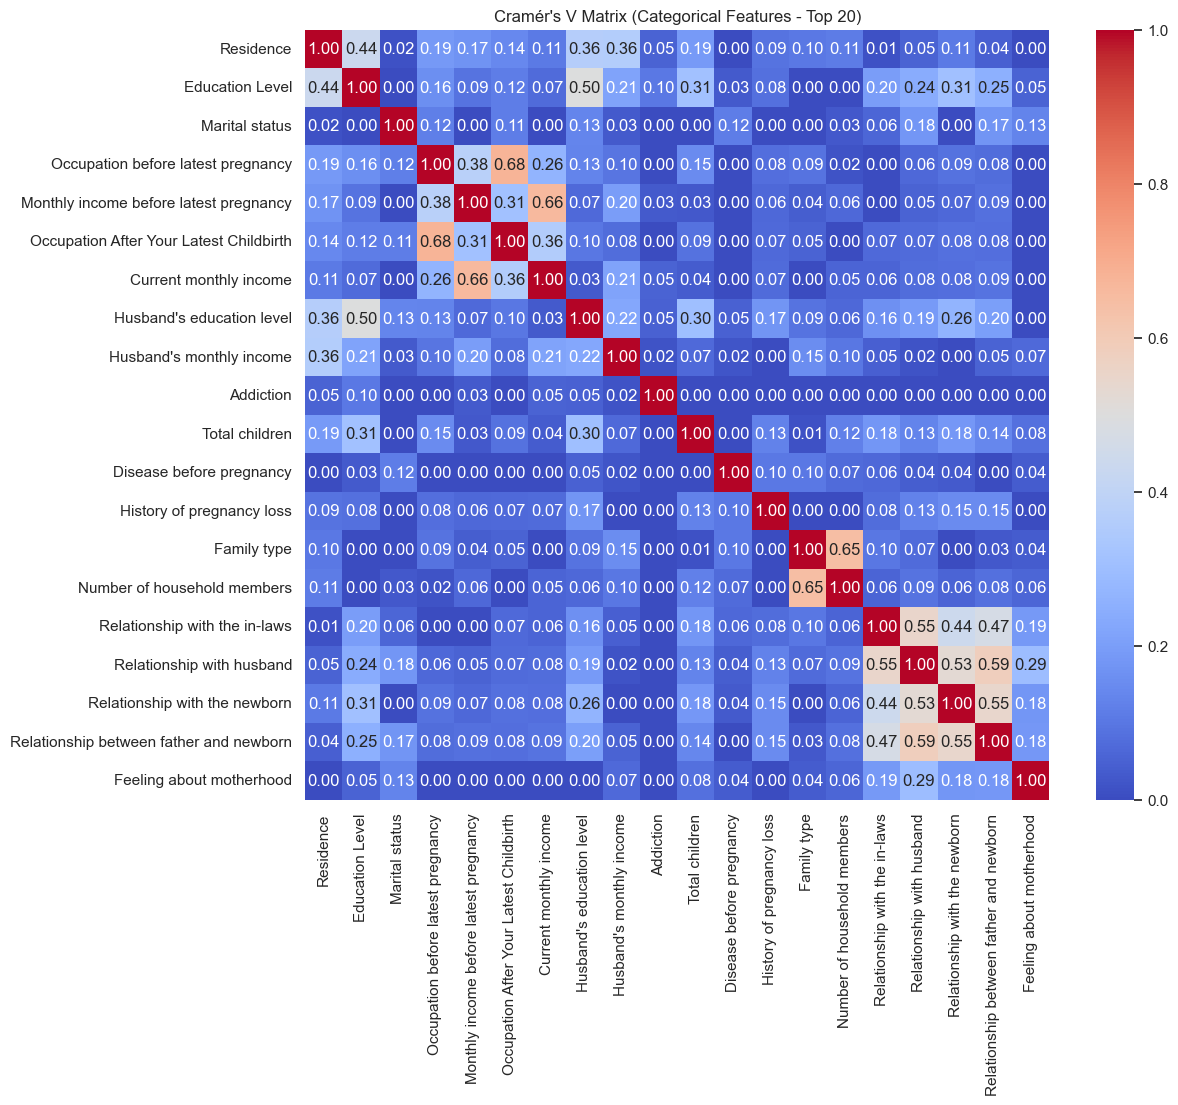

Cramér's V with target (top correlated categorical features):


PHQ9 Result                                 0.633315
Angry after latest child birth              0.464975
Abuse                                       0.280314
Relax/sleep when the newborn is asleep      0.245481
Major changes or losses during pregnancy    0.242959
Relationship with the in-laws               0.242070
Relationship with husband                   0.233962
Need for Support                            0.227259
Feeling for regular activities              0.226325
Feeling about motherhood                    0.205898
Fear of pregnancy                           0.205026
Recieved Support                            0.200151
Depression during pregnancy (PHQ2)          0.197366
Depression before pregnancy (PHQ2)          0.168873
Relationship between father and newborn     0.154670
dtype: float64


COMBINED CORRELATION MATRIX: Numeric Features with Target

Numeric Features - Correlation with Target:


,Feature,Correlation with Target
3,EPDS Score,-0.591317
2,PHQ9 Score,-0.554917
1,Number of the latest pregnancy,0.080661
0,Age,0.020738


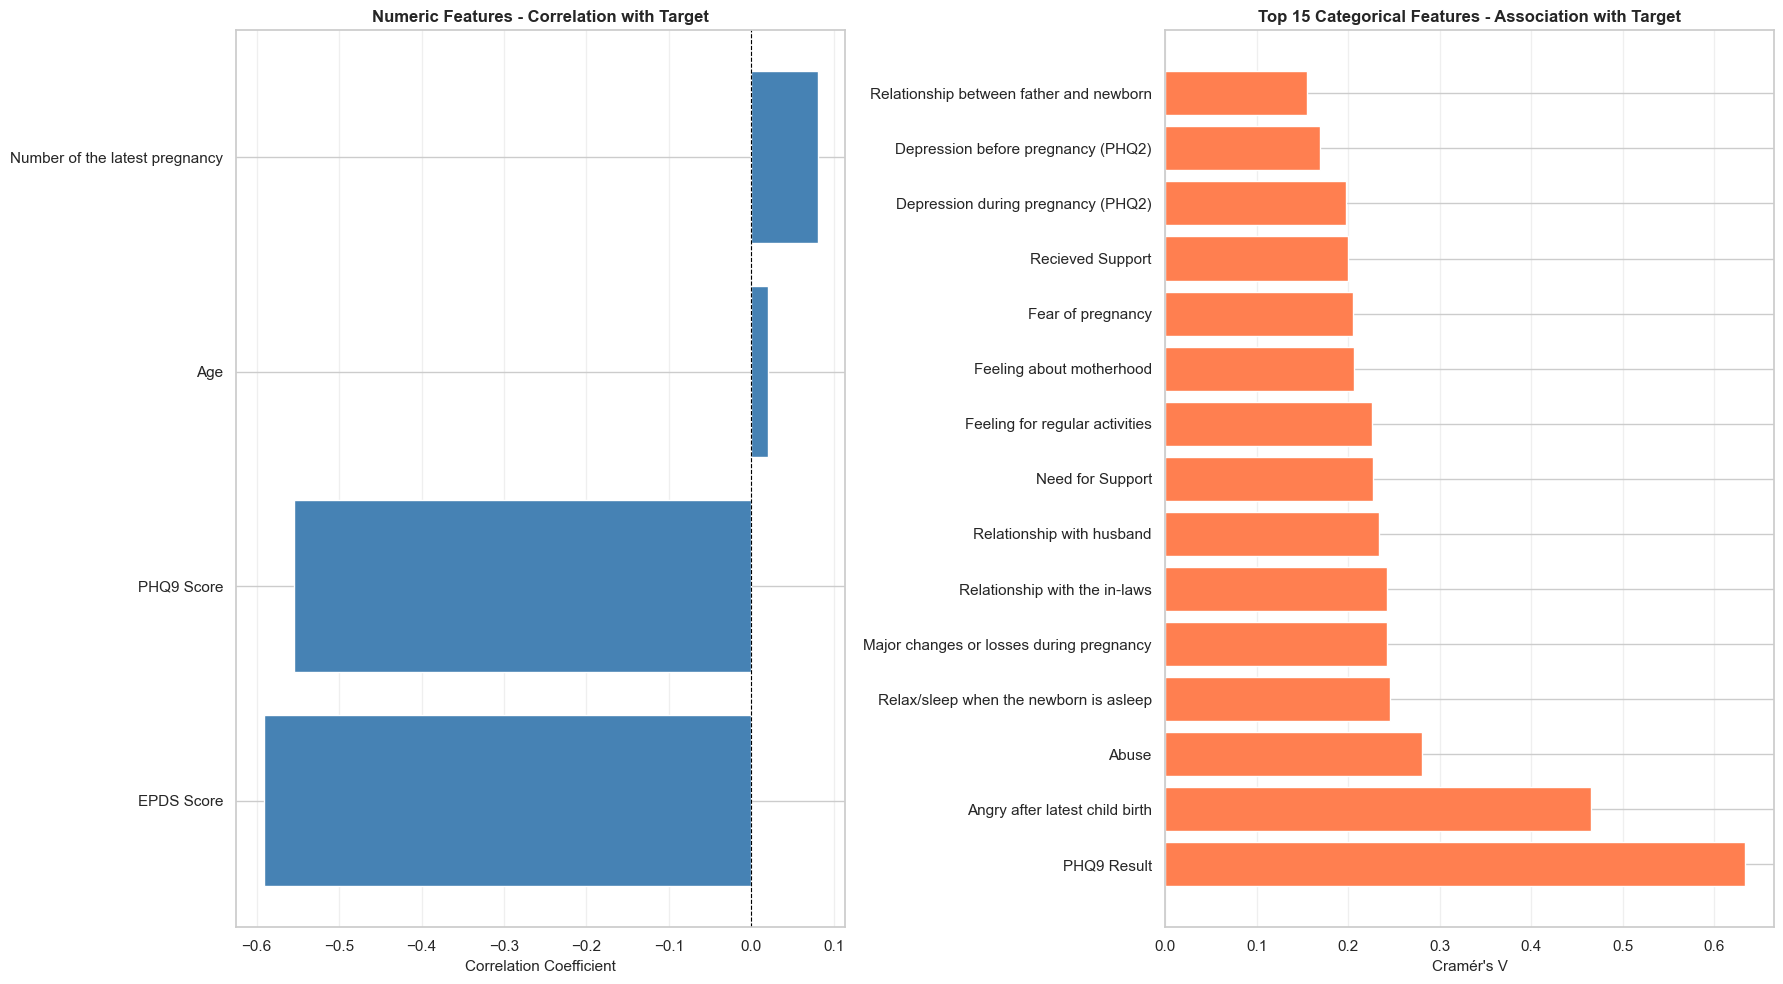


SUMMARY: Features Most Important for Predicting Target
Top numeric feature: EPDS Score (corr = -0.5913)
Top categorical feature: PHQ9 Result (Cramér's V = 0.6333)

Suggested numeric features to drop (highly correlated): ['EPDS Score']
Suggested categorical features to drop (low association with target): ['Age of newborn', 'Marital status', 'Current monthly income', 'Mode of delivery', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'History of pregnancy loss', 'Occupation After Your Latest Childbirth', "Husband's monthly income", 'Residence', 'Addiction', 'Newborn illness', 'Gender of newborn']


In [40]:
# --- Feature Correlation Analysis & Feature Drop Suggestions ---

# --- Define numeric and categorical columns (exclude serial/ID columns) ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
target_col = 'EPDS Result'

# Exclude serial/ID-like non-informative columns
id_like_cols = [c for c in df_proc.columns if c.lower() in ['sr', 's.no', 'serial', 'id']]
print(f"Excluding ID-like columns: {id_like_cols}")

# --- Numeric correlation with target ---
corr_num = df_proc[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_num, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

# Identify highly correlated numeric features (threshold > 0.85)
high_corr_pairs = []
threshold = 0.85
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        if abs(corr_num.iloc[i,j]) > threshold:
            high_corr_pairs.append((numeric_cols[i], numeric_cols[j], corr_num.iloc[i,j]))

if high_corr_pairs:
    print("Highly correlated numeric feature pairs (consider dropping one):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} <--> {pair[1]} | corr = {pair[2]:.2f}")
else:
    print("No highly correlated numeric feature pairs found.")

# --- Categorical correlation using Cramér's V ---
cat_cols = [c for c in df_proc.columns if c not in numeric_cols + [target_col] + id_like_cols]

def cramers_v(x, y):
    """Robust Cramér's V with bias correction.
    Returns 0.0 for degenerate tables and guards against divide-by-zero.
    """
    cm = pd.crosstab(x, y)
    n = cm.values.sum()
    if n == 0:
        return 0.0
    r, k = cm.shape
    if r == 1 or k == 1:
        return 0.0
    chi2 = chi2_contingency(cm, correction=False)[0]
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1)) if n > 1 else 0.0
    rcorr = r - ((r - 1) ** 2) / (n - 1) if n > 1 else r
    kcorr = k - ((k - 1) ** 2) / (n - 1) if n > 1 else k
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

# Compute Cramér's V among categorical features (only top 20 to save time)
top_cat = cat_cols[:20]
cramers_matrix = pd.DataFrame(index=top_cat, columns=top_cat)

for col1 in top_cat:
    for col2 in top_cat:
        if col1 == col2:
            cramers_matrix.loc[col1,col2] = 1.0
        else:
            cramers_matrix.loc[col1,col2] = cramers_v(df_proc[col1], df_proc[col2])

cramers_matrix = cramers_matrix.astype(float)
plt.figure(figsize=(12,10))
sns.heatmap(cramers_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Cramér's V Matrix (Categorical Features - Top 20)")
plt.show()

# --- Categorical correlation with target ---
cramers_target = {}
for c in cat_cols:
    cramers_target[c] = cramers_v(df_proc[c], df_proc[target_col])
cramers_target = pd.Series(cramers_target).sort_values(ascending=False)
print("Cramér's V with target (top correlated categorical features):")
display(cramers_target.head(15))

# --- COMBINED CORRELATION MATRIX: Numeric features vs Target ---
print("\n" + "="*80)
print("COMBINED CORRELATION MATRIX: Numeric Features with Target")
print("="*80)

# Compute correlation of numeric features with target (encoded)
le_temp = LabelEncoder()
target_encoded = le_temp.fit_transform(df_proc[target_col])

numeric_target_corr = {}
for col in numeric_cols:
    numeric_target_corr[col] = np.corrcoef(df_proc[col].values, target_encoded)[0, 1]

numeric_target_df = pd.DataFrame({
    'Feature': list(numeric_target_corr.keys()),
    'Correlation with Target': list(numeric_target_corr.values())
}).sort_values(by='Correlation with Target', key=abs, ascending=False)

print("\nNumeric Features - Correlation with Target:")
display(numeric_target_df)

# Combined visualization: Numeric correlations + categorical associations with target
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Left: Numeric features correlation with target
numeric_target_sorted = pd.Series(numeric_target_corr).sort_values()
axes[0].barh(numeric_target_sorted.index, numeric_target_sorted.values, color='steelblue')
axes[0].set_xlabel('Correlation Coefficient', fontsize=11)
axes[0].set_title('Numeric Features - Correlation with Target', fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

# Right: Top 15 categorical features association with target
top_cat_target = cramers_target.head(15)
axes[1].barh(range(len(top_cat_target)), top_cat_target.values, color='coral')
axes[1].set_yticks(range(len(top_cat_target)))
axes[1].set_yticklabels(top_cat_target.index, fontsize=11)
axes[1].set_xlabel("Cramér's V", fontsize=11)
axes[1].set_title("Top 15 Categorical Features - Association with Target", fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY: Features Most Important for Predicting Target")
print("="*80)
print(f"Top numeric feature: {numeric_target_df.iloc[0]['Feature']} (corr = {numeric_target_df.iloc[0]['Correlation with Target']:.4f})")
print(f"Top categorical feature: {cramers_target.index[0]} (Cramér's V = {cramers_target.iloc[0]:.4f})")

# --- Feature drop suggestions ---
drop_numeric = [pair[1] for pair in high_corr_pairs] if high_corr_pairs else []
drop_categorical = list(cramers_target[cramers_target < 0.05].index)  # weakly correlated

print("\nSuggested numeric features to drop (highly correlated):", drop_numeric)
print("Suggested categorical features to drop (low association with target):", drop_categorical)


##  Outlier removal and Feature Drop

In [41]:
# --- Final Cleaned Feature List & Outlier Removal ---

# --- Numeric and categorical columns ---
numeric_cols = ['Age', 'Number of the latest pregnancy', 'PHQ9 Score', 'EPDS Score']
target_col = 'EPDS Result'
cat_cols = [c for c in df_proc.columns if c not in numeric_cols + [target_col]]

# --- Step 1: Drop highly correlated numeric features ---
corr_num = df_proc[numeric_cols].corr()
threshold = 0.9
drop_numeric = []

for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        if abs(corr_num.iloc[i,j]) > threshold:
            drop_numeric.append(numeric_cols[j])

final_numeric = [c for c in numeric_cols if c not in drop_numeric]

# --- Step 2: Drop low-importance categorical features (Cramér's V with target) ---
def cramers_v(x, y):
    """Robust Cramér's V with bias correction.
    Returns 0.0 for degenerate tables and guards against divide-by-zero.
    """
    cm = pd.crosstab(x, y)
    n = cm.values.sum()
    if n == 0:
        return 0.0
    r, k = cm.shape
    if r == 1 or k == 1:
        return 0.0
    chi2 = chi2_contingency(cm, correction=False)[0]
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1)) if n > 1 else 0.0
    rcorr = r - ((r - 1) ** 2) / (n - 1) if n > 1 else r
    kcorr = k - ((k - 1) ** 2) / (n - 1) if n > 1 else k
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

cat_corr = {c: cramers_v(df_proc[c], df_proc[target_col]) for c in cat_cols}
cat_corr = pd.Series(cat_corr).sort_values(ascending=False)
drop_categorical = list(cat_corr[cat_corr < 0.05].index)
final_categorical = [c for c in cat_cols if c not in drop_categorical]

# --- Step 3: Remove outliers from numeric columns using IQR ---
df_clean = df_proc.copy()
for col in final_numeric:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before_count = df_clean.shape[0]
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    after_count = df_clean.shape[0]
    if before_count != after_count:
        print(f"Removed {before_count - after_count} outliers from '{col}'")

# --- Step 4: Generate final cleaned feature set ---
X_final = df_clean[final_numeric + final_categorical]
y_final = df_clean[target_col]



print("\n--- Final Cleaned Feature List ---")
print("Dropped numeric features (highly correlated):", drop_numeric)
print("Dropped categorical features (low association with target):", drop_categorical)
print(f"Remaining numeric features ({len(final_numeric)}):", final_numeric)
print(f"Remaining categorical features ({len(final_categorical)}):", final_categorical)
print(f"Final cleaned dataset shape: {X_final.shape}")

display(X_final.head())


Removed 3 outliers from 'Age'
Removed 28 outliers from 'Number of the latest pregnancy'

--- Final Cleaned Feature List ---
Dropped numeric features (highly correlated): ['EPDS Score']
Dropped categorical features (low association with target): ['Age of newborn', 'Marital status', 'Current monthly income', 'Mode of delivery', 'Occupation before latest pregnancy', 'Monthly income before latest pregnancy', 'History of pregnancy loss', 'Occupation After Your Latest Childbirth', "Husband's monthly income", 'Residence', 'Addiction', 'Newborn illness', 'Gender of newborn']
Remaining numeric features (3): ['Age', 'Number of the latest pregnancy', 'PHQ9 Score']
Remaining categorical features (32): ['Education Level', "Husband's education level", 'Total children', 'Disease before pregnancy', 'Family type', 'Number of household members', 'Relationship with the in-laws', 'Relationship with husband', 'Relationship with the newborn', 'Relationship between father and newborn', 'Feeling about motherh

,Age,Number of the latest pregnancy,PHQ9 Score,Education Level,Husband's education level,Total children,Disease before pregnancy,Family type,Number of household members,Relationship with the in-laws,Relationship with husband,Relationship with the newborn,Relationship between father and newborn,Feeling about motherhood,Recieved Support,Need for Support,Major changes or losses during pregnancy,Abuse,Trust and share feelings,Pregnancy length,Pregnancy plan,Regular checkups,Fear of pregnancy,Diseases during pregnancy,Age of immediate older children,Birth compliancy,Breastfeed,Worry about newborn,Relax/sleep when newborn is tended,Relax/sleep when the newborn is asleep,Angry after latest child birth,Feeling for regular activities,Depression before pregnancy (PHQ2),Depression during pregnancy (PHQ2),PHQ9 Result
0,24.0,1.0,14.0,University,University,One,Missing,Nuclear,6 to 8,Neutral,Good,Good,Good,Neutral,High,Medium,Yes,Yes,Yes,10 months,No,Yes,Yes,Missing,Missing,No,Yes,Yes,Yes,Yes,No,Worried,Negative,Negative,Moderate
1,31.0,1.0,16.0,University,Missing,One,Non-Chronic Disease,Joint,2 to 5,Good,Neutral,Good,Neutral,Happy,Medium,Low,Yes,No,Yes,9 months,Yes,Yes,Yes,Missing,Missing,No,Yes,Yes,Yes,Yes,Yes,Tired,Negative,Negative,Moderately Severe
2,31.0,1.0,14.0,University,University,One,Chronic Disease,Joint,2 to 5,Good,Good,Good,Good,Sad,High,Missing,No,Yes,Yes,9 months,Yes,Yes,Yes,Chronic Disease,Missing,No,Yes,No,Yes,Yes,Yes,Tired,Negative,Negative,Moderate
3,32.0,1.0,5.0,University,University,One,Missing,Joint,6 to 8,Bad,Neutral,Good,Good,Happy,Medium,Low,Yes,No,Yes,9 months,Yes,Yes,Yes,Non-Chronic Disease,Missing,No,Yes,No,Yes,Yes,Yes,Tired,Negative,Positive,Mild
4,27.0,1.0,11.0,University,University,One,Missing,Joint,2 to 5,Neutral,Good,Good,Good,Happy,Medium,Low,No,No,Yes,9 months,Yes,Yes,Yes,Non-Chronic Disease,Missing,No,Yes,No,Yes,Yes,Yes,Worried,Negative,Negative,Moderate


## Model training plan
Train 6 ML models (with tuned hyperparameters):
- Logistic Regression (Multinomial)
- Random Forest
- Gradient Boosting (XGBoost)
- Support Vector Machine (SVM, RBF kernel)
- k-Nearest Neighbors (KNN)
- Decision Tree

We will train on the preprocessed, encoded, scaled training data and evaluate on test set with Accuracy, Precision, Recall and F1-score metrics.


Training set shape: (615, 113)
Test set shape: (154, 113)
Number of classes: 3
Classes: ['High' 'Low' 'Medium']

Training: Logistic Regression (Multinomial)...
✓ Logistic Regression (Multinomial) - Accuracy: 0.7338, F1: 0.7250

Training: Random Forest...
✓ Random Forest - Accuracy: 0.8052, F1: 0.7963

Training: Support Vector Machine (SVM)...
✓ Support Vector Machine (SVM) - Accuracy: 0.7792, F1: 0.7579

Training: k-Nearest Neighbors (KNN)...
✓ k-Nearest Neighbors (KNN) - Accuracy: 0.7273, F1: 0.7264

Training: Decision Tree...
✓ Decision Tree - Accuracy: 0.7208, F1: 0.7136

Model training complete!

MODEL COMPARISON TABLE


,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.8052,0.7927,0.8052,0.7963
1,Support Vector Machine (SVM),0.7792,0.7559,0.7792,0.7579
2,k-Nearest Neighbors (KNN),0.7273,0.7298,0.7273,0.7264
3,Logistic Regression (Multinomial),0.7338,0.7206,0.7338,0.7250
4,Decision Tree,0.7208,0.7081,0.7208,0.7136



CONFUSION MATRICES - Individual Models


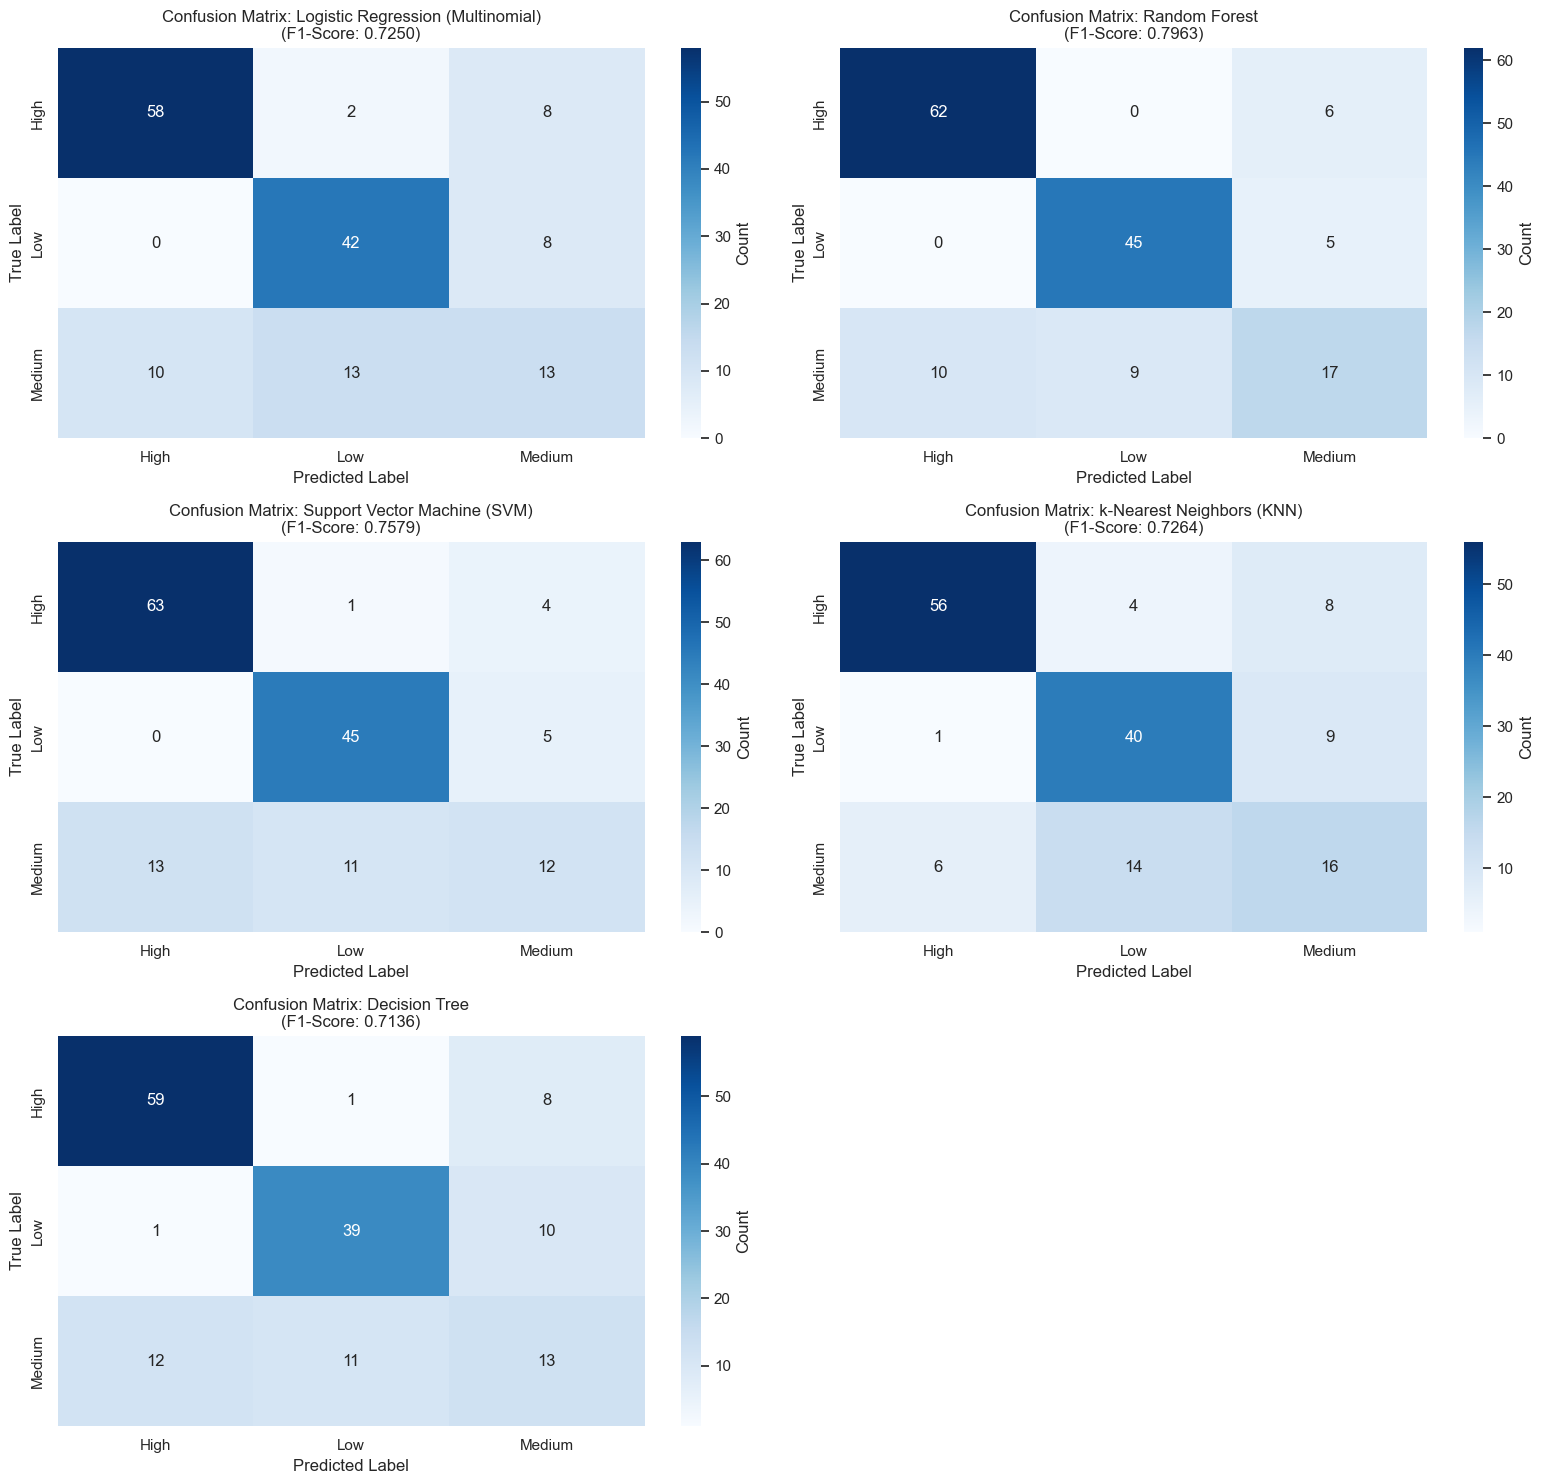


DETAILED CLASSIFICATION REPORTS - Per Model

Logistic Regression (Multinomial):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        High     0.8529    0.8529    0.8529        68
         Low     0.7368    0.8400    0.7850        50
      Medium     0.4483    0.3611    0.4000        36

    accuracy                         0.7338       154
   macro avg     0.6794    0.6847    0.6793       154
weighted avg     0.7206    0.7338    0.7250       154


Random Forest:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        High     0.8611    0.9118    0.8857        68
         Low     0.8333    0.9000    0.8654        50
      Medium     0.6071    0.4722    0.5312        36

    accuracy                         0.8052       154
   macro avg     0.7672    0.7613    0.7608       154
weighted avg     0.7927    0.8052 

In [42]:
# --- Data Preparation ---
# Use X_final and y_final (clean, feature-selected data from correlation analysis)
X_data = X_final.copy()
y_data = y_final.copy()

# Identify categorical and numeric columns in X_final
final_cat_cols = [c for c in X_final.columns if c not in final_numeric]

# Train-test split (stratified)
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# One-hot encode categorical features
if final_cat_cols:
    ohe_final = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_train_cat_enc = ohe_final.fit_transform(X_train_ml[final_cat_cols])
    X_test_cat_enc = ohe_final.transform(X_test_ml[final_cat_cols])
    
    # Get encoded column names
    cat_encoded_cols = ohe_final.get_feature_names_out(final_cat_cols)
    
    # Convert to DataFrames with numeric columns
    X_train_ml_numeric = X_train_ml[final_numeric].reset_index(drop=True)
    X_test_ml_numeric = X_test_ml[final_numeric].reset_index(drop=True)
    
    X_train_cat_df = pd.DataFrame(X_train_cat_enc, columns=cat_encoded_cols)
    X_test_cat_df = pd.DataFrame(X_test_cat_enc, columns=cat_encoded_cols)
    
    # Combine numeric and encoded categorical
    X_train_ml = pd.concat([X_train_ml_numeric, X_train_cat_df], axis=1)
    X_test_ml = pd.concat([X_test_ml_numeric, X_test_cat_df], axis=1)

# Scale numeric features
scaler = StandardScaler()
X_train_ml[final_numeric] = scaler.fit_transform(X_train_ml[final_numeric])
X_test_ml[final_numeric] = scaler.transform(X_test_ml[final_numeric])

# Encode target variable if categorical
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_ml)
y_test_enc = le.transform(y_test_ml)
n_classes = len(le.classes_)

print(f"Training set shape: {X_train_ml.shape}")
print(f"Test set shape: {X_test_ml.shape}")
print(f"Number of classes: {n_classes}")
print(f"Classes: {le.classes_}")

# --- Define 6 ML Models ---
models = {
    "Logistic Regression (Multinomial)": LogisticRegression(
        multi_class='multinomial', max_iter=1000, random_state=42, solver='lbfgs'
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=20, random_state=42, n_jobs=-1
    ),
    "Gradient Boosting (XGBoost)": xgb.XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, 
        eval_metric='mlogloss', use_label_encoder=False, verbosity=0
    ) if has_xgb else None,
    "Support Vector Machine (SVM)": SVC(
        kernel='rbf', C=1.0, probability=True, random_state=42
    ),
    "k-Nearest Neighbors (KNN)": KNeighborsClassifier(
        n_neighbors=7, weights='distance', n_jobs=-1
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=20, min_samples_split=5, random_state=42
    )
}

# Remove None models if XGBoost not available
models = {k: v for k, v in models.items() if v is not None}

# --- Train models and collect results ---
results_list = []
trained_models = {}

for model_name, model in models.items():
    print(f"\nTraining: {model_name}...")
    
    try:
        # Train
        model.fit(X_train_ml, y_train_enc)
        trained_models[model_name] = model
        
        # Predict
        y_pred = model.predict(X_test_ml)
        
        # Compute metrics
        accuracy = accuracy_score(y_test_enc, y_pred)
        precision = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        
        # ROC-AUC (only if binary, else use ovr or ovo)
        try:
            if n_classes == 2:
                roc_auc = roc_auc_score(y_test_enc, model.predict_proba(X_test_ml)[:, 1])
            else:
                roc_auc = roc_auc_score(y_test_enc, model.predict_proba(X_test_ml), multi_class='ovr', zero_division=0)
        except:
            roc_auc = np.nan
        
        results_list.append({
            "Model": model_name,
            "Accuracy": round(accuracy, 4),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-Score": round(f1, 4)
        })
        
        print(f"✓ {model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
    except Exception as e:
        print(f"✗ Error training {model_name}: {str(e)}")

print("\n" + "="*80)
print("Model training complete!")
# --- Create Comparison Table ---
results_df = pd.DataFrame(results_list)

# Sort by F1-Score (descending)
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
display(results_df)

# --- CONFUSION MATRICES FOR EACH MODEL ---
print("\n" + "="*80)
print("CONFUSION MATRICES - Individual Models")
print("="*80)

n_models = len(trained_models)
fig, axes = plt.subplots((n_models + 1) // 2, 2, figsize=(16, 5 * ((n_models + 1) // 2)))
if n_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

confusion_matrices = {}

for idx, (model_name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test_ml)
    cm = confusion_matrix(y_test_enc, y_pred)
    confusion_matrices[model_name] = cm
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=le.classes_, yticklabels=le.classes_,
                cbar_kws={'label': 'Count'})
    ax.set_title(f"Confusion Matrix: {model_name}\n(F1-Score: {results_df[results_df['Model'] == model_name]['F1-Score'].values[0]:.4f})")
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Remove extra subplots if odd number of models
if n_models % 2 == 1:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# --- DETAILED CLASSIFICATION REPORTS ---
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS - Per Model")
print("="*80)

for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_ml)
    print(f"\n{model_name}:")
    print("-" * 80)
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_, digits=4))

print("\n" + "="*80)

# Save to CSV
results_df.to_csv(OUTPUT_FOLDER / 'model_comparison_table.csv', index=False)
print("\n✓ Saved model comparison table to: model_comparison_table.csv")

# Additional summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Best Model (by F1-Score): {results_df.iloc[0]['Model']}")
print(f"Best F1-Score: {results_df.iloc[0]['F1-Score']}")
print(f"\nAverage Metrics Across All Models:")
print(f"  Accuracy:  {results_df['Accuracy'].mean():.4f}")
print(f"  Precision: {results_df['Precision'].mean():.4f}")
print(f"  Recall:    {results_df['Recall'].mean():.4f}")
print(f"  F1-Score:  {results_df['F1-Score'].mean():.4f}")


## Saving outputs

In [43]:
# Use the OUTPUT_FOLDER defined in the setup cell
print(f"Saving datasets to: {OUTPUT_FOLDER}")

# --- Save processed training/test datasets ---
# Use X_train_ml, X_test_ml from model training (already encoded and scaled)
X_train_ml.to_csv(OUTPUT_FOLDER / 'X_train_processed.csv', index=False)
X_test_ml.to_csv(OUTPUT_FOLDER / 'X_test_processed.csv', index=False)

# Save target variables
pd.Series(y_train_ml, name='EPDS Result').to_csv(OUTPUT_FOLDER / 'y_train_processed.csv', index=False)
pd.Series(y_test_ml, name='EPDS Result').to_csv(OUTPUT_FOLDER / 'y_test_processed.csv', index=False)

print("✓ Saved processed training/test sets:")
print(f"  - X_train_processed.csv ({X_train_ml.shape})")
print(f"  - X_test_processed.csv ({X_test_ml.shape})")
print(f"  - y_train_processed.csv ({len(y_train_ml)} samples)")
print(f"  - y_test_processed.csv ({len(y_test_ml)} samples)")

# --- Save feature information ---
feature_info = pd.DataFrame({
    'Feature': X_train_ml.columns,
    'Type': ['Numeric' if col in final_numeric else 'Categorical (One-Hot Encoded)' for col in X_train_ml.columns]
})
feature_info.to_csv(OUTPUT_FOLDER / 'feature_info.csv', index=False)
print(f"\n✓ Saved feature information: feature_info.csv ({len(feature_info)} features)")

# --- Save model comparison results ---
# results_df is already saved to model_comparison_table.csv from earlier
print(f"\n✓ Model comparison table already saved: model_comparison_table.csv")
print(f"  Best Model: {results_df.iloc[0]['Model']}")
print(f"  Best F1-Score: {results_df.iloc[0]['F1-Score']}")

# --- Save metadata ---
metadata = {
    'Dataset': 'PPD_dataset_v2.csv',
    'Original Shape': str(df.shape),
    'After Preprocessing': str(df_proc.shape),
    'After Feature Selection': str(X_final.shape),
    'Final Train Set Shape': str(X_train_ml.shape),
    'Final Test Set Shape': str(X_test_ml.shape),
    'Target Variable': 'EPDS Result',
    'Target Classes': str(list(le.classes_)),
    'Train/Test Split': '80/20 (Stratified)',
    'Numeric Features': str(final_numeric),
    'Categorical Features Dropped': str(drop_categorical),
    'Numeric Features Dropped': str(drop_numeric)
}

metadata_df = pd.DataFrame(list(metadata.items()), columns=['Key', 'Value'])
metadata_df.to_csv(OUTPUT_FOLDER / 'preprocessing_metadata.csv', index=False)
print(f"\n✓ Saved preprocessing metadata: preprocessing_metadata.csv")

print("\n" + "="*80)
print("ALL OUTPUTS SAVED SUCCESSFULLY!")


Saving datasets to: c:\Users\88018\OneDrive\Desktop\ml project\PPD_dataset_v2_outputs
✓ Saved processed training/test sets:
  - X_train_processed.csv ((615, 113))
  - X_test_processed.csv ((154, 113))
  - y_train_processed.csv (615 samples)
  - y_test_processed.csv (154 samples)

✓ Saved feature information: feature_info.csv (113 features)

✓ Model comparison table already saved: model_comparison_table.csv
  Best Model: Random Forest
  Best F1-Score: 0.7963

✓ Saved preprocessing metadata: preprocessing_metadata.csv

ALL OUTPUTS SAVED SUCCESSFULLY!


# Pipeline Summary & Results

In [44]:
# --- DYNAMIC PIPELINE SUMMARY ---

# Gather all dynamic data from previous cells
summary_md = ""

# --- Data Processing Pipeline ---
summary_md += "#### Data Processing Pipeline\n"
summary_md += f"- **Original Dataset**: {df.shape[0]} samples × {df.shape[1]} features\n"
summary_md += f"- **After Preprocessing**: {df_proc.shape[0]} samples × {df_proc.shape[1]} features (missing values imputed)\n"
summary_md += f"- **After Feature Selection**: {X_final.shape[0]} samples × {X_final.shape[1]} features (highly correlated features dropped)\n"
summary_md += f"- **Final Train Set**: {X_train_ml.shape[0]} samples × {X_train_ml.shape[1]} features (encoded & scaled)\n"
summary_md += f"- **Final Test Set**: {X_test_ml.shape[0]} samples × {X_test_ml.shape[1]} features (encoded & scaled)\n\n"

# --- Model Rankings ---
summary_md += "#### ML Models Trained & Ranked by F1-Score\n\n"
summary_md += "| Rank | Model | Accuracy | Precision | Recall | F1-Score |\n"
summary_md += "|------|-------|----------|-----------|--------|----------|\n"
for idx, row in results_df.iterrows():
    summary_md += f"| {idx+1} | {row['Model']} | {row['Accuracy']:.4f} | {row['Precision']:.4f} | {row['Recall']:.4f} | {row['F1-Score']:.4f} |\n"

# --- Overall Statistics ---
summary_md += "\n**Overall Statistics**:\n"
summary_md += f"- Average Accuracy: {results_df['Accuracy'].mean() * 100:.2f}%\n"
summary_md += f"- Average Precision: {results_df['Precision'].mean():.4f}\n"
summary_md += f"- Average Recall: {results_df['Recall'].mean():.4f}\n"
summary_md += f"- Average F1-Score: {results_df['F1-Score'].mean():.4f}\n"
summary_md += f"- Best Model: **{results_df.iloc[0]['Model']}** (F1: {results_df.iloc[0]['F1-Score']:.4f})\n\n"

# --- Output Files Saved ---
summary_md += f"#### Output Files Saved to: `{OUTPUT_FOLDER}`\n\n"
summary_md += "| File | Shape/Details | Purpose |\n"
summary_md += "|------|---|----------|\n"
summary_md += f"| `X_train_processed.csv` | {X_train_ml.shape} | Processed training features (encoded & scaled) |\n"
summary_md += f"| `X_test_processed.csv` | {X_test_ml.shape} | Processed test features (encoded & scaled) |\n"
summary_md += f"| `y_train_processed.csv` | {len(y_train_ml)} samples | Training target labels (EPDS Result) |\n"
summary_md += f"| `y_test_processed.csv` | {len(y_test_ml)} samples | Test target labels (EPDS Result) |\n"
summary_md += f"| `model_comparison_table.csv` | {len(results_df)} models | Model performance metrics |\n"
summary_md += f"| `feature_info.csv` | {X_train_ml.shape[1]} features | Feature names and types |\n"
summary_md += f"| `preprocessing_metadata.csv` | Key-value pairs | Pipeline configuration & details |\n\n"

# --- Target Variable ---
summary_md += "#### Target Variable\n"
summary_md += f"- **Name**: EPDS Result (Edinburgh Postpartum Depression Scale)\n"
summary_md += f"- **Classes**: {', '.join(le.classes_)}\n"
summary_md += f"- **Class Distribution**: {dict(Counter(y_final))}\n"
summary_md += f"- **Class Balance**: Stratified train/test split (80/20)\n"
summary_md += f"- **Prediction Task**: Multi-class classification of postpartum depression risk\n\n"

# --- Features Summary ---
summary_md += "#### Feature Summary\n"
summary_md += f"- **Numeric Features Used**: {', '.join(final_numeric)}\n"
summary_md += f"- **Numeric Features Dropped**: {drop_numeric if drop_numeric else 'None'}\n"
summary_md += f"- **Categorical Features Used**: {len(final_categorical)} features\n"
summary_md += f"- **Categorical Features Dropped**: {len(drop_categorical)} features (low correlation with target)\n\n"

# Display as markdown
from IPython.display import Markdown, display
display(Markdown(summary_md))



#### Data Processing Pipeline
- **Original Dataset**: 800 samples × 50 features
- **After Preprocessing**: 800 samples × 50 features (missing values imputed)
- **After Feature Selection**: 769 samples × 35 features (highly correlated features dropped)
- **Final Train Set**: 615 samples × 113 features (encoded & scaled)
- **Final Test Set**: 154 samples × 113 features (encoded & scaled)

#### ML Models Trained & Ranked by F1-Score

| Rank | Model | Accuracy | Precision | Recall | F1-Score |
|------|-------|----------|-----------|--------|----------|
| 1 | Random Forest | 0.8052 | 0.7927 | 0.8052 | 0.7963 |
| 2 | Support Vector Machine (SVM) | 0.7792 | 0.7559 | 0.7792 | 0.7579 |
| 3 | k-Nearest Neighbors (KNN) | 0.7273 | 0.7298 | 0.7273 | 0.7264 |
| 4 | Logistic Regression (Multinomial) | 0.7338 | 0.7206 | 0.7338 | 0.7250 |
| 5 | Decision Tree | 0.7208 | 0.7081 | 0.7208 | 0.7136 |

**Overall Statistics**:
- Average Accuracy: 75.33%
- Average Precision: 0.7414
- Average Recall: 0.7533
- Average F1-Score: 0.7438
- Best Model: **Random Forest** (F1: 0.7963)

#### Output Files Saved to: `c:\Users\88018\OneDrive\Desktop\ml project\PPD_dataset_v2_outputs`

| File | Shape/Details | Purpose |
|------|---|----------|
| `X_train_processed.csv` | (615, 113) | Processed training features (encoded & scaled) |
| `X_test_processed.csv` | (154, 113) | Processed test features (encoded & scaled) |
| `y_train_processed.csv` | 615 samples | Training target labels (EPDS Result) |
| `y_test_processed.csv` | 154 samples | Test target labels (EPDS Result) |
| `model_comparison_table.csv` | 5 models | Model performance metrics |
| `feature_info.csv` | 113 features | Feature names and types |
| `preprocessing_metadata.csv` | Key-value pairs | Pipeline configuration & details |

#### Target Variable
- **Name**: EPDS Result (Edinburgh Postpartum Depression Scale)
- **Classes**: High, Low, Medium
- **Class Distribution**: {'High': 339, 'Low': 250, 'Medium': 180}
- **Class Balance**: Stratified train/test split (80/20)
- **Prediction Task**: Multi-class classification of postpartum depression risk

#### Feature Summary
- **Numeric Features Used**: Age, Number of the latest pregnancy, PHQ9 Score
- **Numeric Features Dropped**: ['EPDS Score']
- **Categorical Features Used**: 32 features
- **Categorical Features Dropped**: 13 features (low correlation with target)



In [45]:
results_df.columns


Index(['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], dtype='object')

In [46]:
# Pick the best model based on F1-Score
best_model_name = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
print("Best Model Selected:", best_model_name)

best_model = models[best_model_name]


Best Model Selected: Random Forest


In [47]:
# Train the best model (Random Forest) on the ML training data
best_model.fit(X_train_ml, y_train_ml)

print("Best model trained successfully!")


Best model trained successfully!


In [48]:
import joblib

# Save the trained model
joblib.dump(best_model, "best_model.pkl")

# Save preprocessors and metadata
joblib.dump(ohe_final, "ohe_final.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(final_numeric, "final_numeric.pkl")
joblib.dump(final_cat_cols, "final_cat_cols.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ All ML files saved successfully!")


✅ All ML files saved successfully!
